In [1]:

import math
import numpy
import librosa
from enum import Enum
import struct

#from scipy.spatial.distance import cdist

NUM_MFCC = 13
NUM_MELS = 40
SAMPLE_RATE = 16000
NUM_FFT = 2048
FFT_ORDER  = 512
LOWER_FREQ = 133.333300
HIGHEST_FREQ = 6855.497600
WINDOW_LENGTH = int(0.10 * SAMPLE_RATE)
HOP_LENGTH = int(0.04 * SAMPLE_RATE)
EMPHASIS_FACTOR = 0.97
DTW_MARGIN = 60

def get_sorted(unsorted):
    sorted = []
    idx_arr = []
    sorted.append(unsorted[0])
    idx_arr.append(0)
    for i in range(1, len(unsorted)):
        inserted = 0
        for j in range(0, len(sorted)):
            if (unsorted[i] < sorted[j]):
                sorted.insert(j, unsorted[i])
                idx_arr.insert(j, i)
                inserted = 1
                break
        if (inserted == 0):
            sorted.append(unsorted[i])
            idx_arr.append(i)
    return sorted, idx_arr

def get_sorted_segments(unsorted, key):
    sorted = []
    sorted.append(unsorted[0])
    for i in range(1, len(unsorted)):
        start, end = 0, len(sorted)-1
        while (start < end):
            mid = int((end - start) / 2) + start
            if (unsorted[i][key] < sorted[mid][key]):
                end = mid - 1
            else:
                start = mid + 1
        assert start >= 0
        assert end <= len(sorted)
        if (unsorted[i][key] > sorted[end][key]):
            if (end == len(sorted)):
                sorted.append(unsorted[i])
            else:        
                sorted.insert(end+1, unsorted[i])
        else:
            sorted.insert(end, unsorted[i])
    return sorted

def get_energy_level_idx(energy_val, 
                    energy_median,
                    energy_max,
                    num_energy_levels_bef_median,
                    num_energy_levels_after_median):

    energy_level_start = 0
    
    for i in range(0, num_energy_levels_bef_median + num_energy_levels_after_median):
        if (i < num_energy_levels_bef_median):
            energy_level_end = energy_level_start + (energy_median/num_energy_levels_bef_median)
        else:
            energy_level_end = energy_level_start + ((energy_max - energy_median)/num_energy_levels_after_median)

        if (energy_level_start <= energy_val <= energy_level_end):
            return i

        energy_level_start = energy_level_end

    print("should not be here: start %.2f end %.2f val %.2f" %(energy_level_start, energy_level_end, energy_val))
    return i

def get_deviation_bkts_with_energy_levels(segments_sorted_array,
                        deviation_median, deviation_max,
                        energy_median, energy_max,
                        num_bkts_bef_median, 
                        num_bkts_after_median, 
                        num_energy_levels_bef_median,
                        num_energy_levels_after_median):

    bkt_arr = []
    start = segments_sorted_array[0]["deviation"]
    for i in range(0, num_bkts_bef_median + num_bkts_after_median):
        bkt = []
        energy_count_arr = numpy.zeros(num_energy_levels_bef_median + num_energy_levels_after_median + 1)
        if (i < num_bkts_bef_median):
            bkt_val = deviation_median/num_bkts_bef_median
        else:
            bkt_val = (deviation_max - deviation_median)/num_bkts_after_median
        
        end = start + bkt_val        
        bkt_arr.append({"bkt":bkt, "energy_count_arr":energy_count_arr,"start":start, "end":end})
        start = end

    curr_bkt = 0
    for i in range(0, len(segments_sorted_array)):
        assert segments_sorted_array[i]["deviation"] >= bkt_arr[curr_bkt]["start"]
        if (segments_sorted_array[i]["deviation"] > bkt_arr[curr_bkt]["end"]):
            curr_bkt += 1
        bkt_arr[curr_bkt]["bkt"].append(segments_sorted_array[i])
        bkt_arr[curr_bkt]["energy_count_arr"][0] += 1

        energy = segments_sorted_array[i]["energy"]
        energy_level_idx = get_energy_level_idx(energy, 
                                        energy_median, energy_max,
                                        num_energy_levels_bef_median,
                                        num_energy_levels_after_median)
        #inc the idx by 1. 0th elem is the total count
        bkt_arr[curr_bkt]["energy_count_arr"][energy_level_idx+1] += 1
    
    return bkt_arr

class AlignmentAlgorithm(Enum):
    DTW_STRIPE = "DTW_STRIPE"
    DTW_EXACT = "DTW_EXACT"

DTW_ALGORITHM = AlignmentAlgorithm.DTW_EXACT


"""
This module contains the implementation
of dynamic time warping (DTW) algorithms
to align two audio waves, represented by their
Mel-frequency cepstral coefficients (MFCCs).

This module contains the following classes:

* :class:`~aeneas.dtw.DTWAlgorithm`,
  an enumeration of the available algorithms;
* :class:`~aeneas.dtw.DTWAligner`,
  the actual wave aligner;
* :class:`~aeneas.dtw.DTWExact`,
  a DTW aligner implementing the exact (full) DTW algorithm;
* :class:`~aeneas.dtw.DTWStripe`,
  a DTW aligner implementing the Sachoe-Chiba band heuristic.

To align two wave files:

1. build an :class:`~aeneas.dtw.DTWAligner` object,
   passing in the constructor
   the paths of the two wave files
   or their MFCC representations;
2. call :func:`~aeneas.dtw.DTWAligner.compute_path`
   to compute the min cost path between
   the MFCC representations of the two wave files.

.. warning:: This module might be refactored in a future version
"""

class aeneas_dtw():

    def __init__(
        self,
        params, q_audio, r_audio
    ):
        self.params = params
        self.query_audio = q_audio 
        self.ref_audio = r_audio
        self._setup_dtw()

    def compute_accumulated_cost_matrix(self):
        """
        Compute the accumulated cost matrix, and return it.

        Return ``None`` if the accumulated cost matrix cannot be computed
        because one of the two waves is empty after masking (if requested).

        :rtype: :class:`numpy.ndarray` (2D)
        :raises: RuntimeError: if both the C extension and
                               the pure Python code did not succeed.

        .. versionadded:: 1.2.0
        """
        if self.dtw is None:
            assert 0
        return self.dtw.compute_accumulated_cost_matrix()

    def compute_path(self):
        """
        Compute the min cost path between the two waves, and return it.

        Return the computed path as a tuple with two elements,
        each being a :class:`numpy.ndarray` (1D) of ``int`` indices: ::

        ([r_1, r_2, ..., r_k], [s_1, s_2, ..., s_k])

        where ``r_i`` are the indices in the real wave
        and ``s_i`` are the indices in the synthesized wave,
        and ``k`` is the length of the min cost path.

        Return ``None`` if the accumulated cost matrix cannot be computed
        because one of the two waves is empty after masking (if requested).

        :rtype: tuple (see above)
        :raises: RuntimeError: if both the C extension and
                               the pure Python code did not succeed.
        """
        wave_path = self.dtw.compute_path()
        return wave_path    

    def _setup_dtw(self):
        """
        Set the DTW object up.
        """

        # setup
        window_shift = self.params.hop_length/self.params.sr
        delta = int(2 * self.params.dtw_margin / window_shift)
        
        # set the selected algorithm
        if self.params.dtw_algorithm == AlignmentAlgorithm.DTW_EXACT:
            self.dtw = DTWExact(
                self.query_audio.mfcc,
                self.ref_audio.mfcc                
            )
        else:
            self.dtw = DTWStripe(
                self.query_audio.mfcc,
                self.ref_audio.mfcc,
                delta
            )

class DTWStripe():

    def __init__(self, m1, m2, delta):
        self.m1 = m1
        self.m2 = m2
        self.delta = delta

    def compute_path(self):
        try:
            cost_matrix, centers = self._compute_cost_matrix()
            accumulated_cost_matrix = self._compute_accumulated_cost_matrix(cost_matrix, centers)
            best_path = self._compute_best_path(accumulated_cost_matrix, centers)
            return best_path
        except Exception as exc:
            print("An unexpected error occurred while running pure Python code", exc, False, None)
        return (False, None)

    def _compute_cost_matrix(self):
        # discard first MFCC component
        mfcc1 = self.m1[1:, :]
        mfcc2 = self.m2[1:, :]
        norm2_1 = numpy.sqrt(numpy.sum(mfcc1 ** 2, 0))
        norm2_2 = numpy.sqrt(numpy.sum(mfcc2 ** 2, 0))
        n = mfcc1.shape[1]
        m = mfcc2.shape[1]
        delta = self.delta
        if delta > m:
            delta = m
        cost_matrix = numpy.zeros((n, delta))
        centers = numpy.zeros(n, dtype=int)
        for i in range(n):
            # center j at row i
            center_j = (m * i) // n
            # COMMENTED self.log([u"Center at row %d is %d", i, center_j])
            range_start = max(0, center_j - (delta // 2))
            range_end = range_start + delta
            if range_end > m:
                range_end = m
                range_start = range_end - delta
            centers[i] = range_start
            # COMMENTED self.log([u"Range at row %d is %d %d", i, range_start, range_end])
            for j in range(range_start, range_end):
                tmp = mfcc1[:, i].transpose().dot(mfcc2[:, j])
                tmp /= norm2_1[i] * norm2_2[j]
                cost_matrix[i][j - range_start] = 1 - tmp
        return (cost_matrix, centers)

    def _compute_accumulated_cost_matrix(self, cost_matrix, centers):
        # create accumulated cost matrix
        #
        # a[i][j] = c[i][j] + min(c[i-1][j-1], c[i-1][j], c[i][j-1])
        #
        return self._compute_acm_in_place(cost_matrix, centers)

    def _compute_acm_in_place(self, cost_matrix, centers):
        n, delta = cost_matrix.shape
        current_row = numpy.copy(cost_matrix[0, :])
        # COMMENTED cost_matrix[0][0] = current_row[0]
        for j in range(1, delta):
            cost_matrix[0][j] = current_row[j] + cost_matrix[0][j - 1]
        # fill table
        for i in range(1, n):
            current_row = numpy.copy(cost_matrix[i, :])
            offset = centers[i] - centers[i - 1]
            for j in range(delta):
                cost0 = numpy.inf
                if (j + offset) < delta:
                    cost0 = cost_matrix[i - 1][j + offset]
                cost1 = numpy.inf
                if j > 0:
                    cost1 = cost_matrix[i][j - 1]
                cost2 = numpy.inf
                if ((j + offset - 1) < delta) and ((j + offset - 1) >= 0):
                    cost2 = cost_matrix[i - 1][j + offset - 1]
                cost_matrix[i][j] = current_row[j] + min(cost0, cost1, cost2)
        return cost_matrix

    def _compute_best_path(self, acc_matrix, centers):
        # get dimensions
        n, delta = acc_matrix.shape
        i = n - 1
        j = delta - 1 + centers[i]
        path = [(i, j)]
        # compute best (min cost) path
        while (i > 0) or (j > 0):
            if i == 0:
                path.append((0, j - 1))
                j -= 1
            elif j == 0:
                path.append((i - 1, 0))
                i -= 1
            else:
                offset = centers[i] - centers[i - 1]
                r_j = j - centers[i]
                cost0 = numpy.inf
                if (r_j + offset) < delta:
                    cost0 = acc_matrix[i - 1][r_j + offset]
                cost1 = numpy.inf
                if r_j > 0:
                    cost1 = acc_matrix[i][r_j - 1]
                cost2 = numpy.inf
                if (r_j > 0) and ((r_j + offset - 1) < delta) and ((r_j + offset - 1) >= 0):
                    cost2 = acc_matrix[i - 1][r_j + offset - 1]
                costs = [
                    cost0,
                    cost1,
                    cost2
                ]
                moves = [
                    (i - 1, j),
                    (i, j - 1),
                    (i - 1, j - 1)
                ]
                min_cost = numpy.argmin(costs)
                # COMMENTED self.log([u"Selected min cost move %d", min_cost])
                min_move = moves[min_cost]
                path.append(min_move)
                i, j = min_move
        return path

class DTWExact():

    def __init__(self, m1, m2):
        self.m1 = m1
        self.m2 = m2

    def compute_accumulated_cost_matrix(self):
        cost_matrix = self._compute_cost_matrix()
        accumulated_cost_matrix = self._compute_accumulated_cost_matrix(cost_matrix)
        return accumulated_cost_matrix

    def compute_path(self):
        accumulated_cost_matrix = self.compute_accumulated_cost_matrix()
        best_path = self._compute_best_path(accumulated_cost_matrix)
        return best_path

    def _compute_cost_matrix(self):
        # discard first MFCC component
        mfcc1 = self.m1[1:, :]
        mfcc2 = self.m2[1:, :]
        norm2_1 = numpy.sqrt(numpy.sum(mfcc1 ** 2, 0))
        norm2_2 = numpy.sqrt(numpy.sum(mfcc2 ** 2, 0))
        # compute dot product
        cost_matrix = mfcc1.transpose().dot(mfcc2)
        # normalize
        norm_matrix = numpy.outer(norm2_1, norm2_2)
        cost_matrix = 1 - (cost_matrix / norm_matrix)
        return cost_matrix

    def _compute_accumulated_cost_matrix(self, cost_matrix):
        # create accumulated cost matrix
        #
        # a[i][j] = c[i][j] + min(c[i-1][j-1], c[i-1][j], c[i][j-1])
        #
        return self._compute_acm_in_place(cost_matrix)

    def _compute_acm_in_place(self, cost_matrix):
        n, m = cost_matrix.shape
        current_row = numpy.copy(cost_matrix[0, :])
        # COMMENTED cost_matrix[0][0] = current_row[0]
        for j in range(1, m):
            cost_matrix[0][j] = current_row[j] + cost_matrix[0][j - 1]
        for i in range(1, n):
            current_row = numpy.copy(cost_matrix[i, :])
            cost_matrix[i][0] = cost_matrix[i - 1][0] + current_row[0]
            for j in range(1, m):
                cost_matrix[i][j] = current_row[j] + min(
                    cost_matrix[i - 1][j],
                    cost_matrix[i][j - 1],
                    cost_matrix[i - 1][j - 1]
                )
        return cost_matrix

    def _compute_best_path(self, acc_matrix):
        # get dimensions
        n, m = acc_matrix.shape
        i = n - 1
        j = m - 1
        path = [(i, j)]
        # compute best (min cost) path
        while (i > 0) or (j > 0):
            if i == 0:
                path.append((0, j - 1))
                j -= 1
            elif j == 0:
                path.append((i - 1, 0))
                i -= 1
            else:
                costs = [
                    acc_matrix[i - 1][j],
                    acc_matrix[i][j - 1],
                    acc_matrix[i - 1][j - 1]
                ]
                moves = [
                    (i - 1, j),
                    (i, j - 1),
                    (i - 1, j - 1)
                ]
                min_cost = numpy.argmin(costs)
                # COMMENTED self.log([u"Selected min cost move %d", min_cost])
                min_move = moves[min_cost]
                path.append(min_move)
                i, j = min_move
        return path

class aeneas_mfcc():
    """
    A class for computing Mel-frequency cepstral coefficients (MFCCs).
    """

    CUTOFF = 0.00001
    """ Cut-off threshold """

    MEL_10 = 2595.0
    """ Base Mel frequency """

    TAG = u"MFCC"

    def __init__(self, params):

        # store parameters in local attributes
        self.filter_bank_size = params.n_mel
        self.mfcc_size = params.n_mfcc
        self.fft_order = params.fft_order
        self.lower_frequency = params.low_freq
        self.upper_frequency = params.high_freq
        self.emphasis_factor = params.emphasis_factor
        self.window_length = params.win_length/params.sr
        self.window_shift = params.hop_length/params.sr

        # initialize DCT matrix
        self._create_dct_matrix()

        # initialized later by compute_from_data()
        self.data = None
        self.sample_rate = None
        self.filters = None
        self.hamming_window = None

    @classmethod
    def _hz2mel(cls, frequency):
        """
        Convert the given frequency in Hz to the Mel scale.

        :param float frequency: the Hz frequency to convert
        :rtype: float
        """
        return cls.MEL_10 * math.log10(1.0 + (frequency / 700.0))

    @classmethod
    def _mel2hz(cls, mel):
        """
        Convert the given Mel value to Hz frequency.

        :param float mel: the Mel value to convert
        :rtype: float
        """
        return 700.0 * (10 ** (mel / cls.MEL_10) - 1)

    def _create_dct_matrix(self):
        """
        Create the not-quite-DCT matrix as used by Sphinx,
        and store it in ```self.s2dct```.
        """
        self.s2dct = numpy.zeros((self.mfcc_size, self.filter_bank_size))
        for i in range(0, self.mfcc_size):
            freq = numpy.pi * float(i) / self.filter_bank_size
            self.s2dct[i] = numpy.cos(freq * numpy.arange(0.5, 0.5 + self.filter_bank_size, 1.0, 'float64'))
        self.s2dct[:, 0] *= 0.5
        self.s2dct = self.s2dct.transpose()

    def _create_mel_filter_bank(self):
        """
        Create the Mel filter bank,
        and store it in ``self.filters``.

        Note that it is a function of the audio sample rate,
        so it cannot be created in the class initializer,
        but only later in :func:`aeneas.mfcc.MFCC.compute_from_data`.
        """
        self.filters = numpy.zeros((1 + (self.fft_order // 2), self.filter_bank_size), 'd')
        dfreq = float(self.sample_rate) / self.fft_order
        nyquist_frequency = self.sample_rate / 2
        if self.upper_frequency > nyquist_frequency:
            self.log_exc(u"Upper frequency %f exceeds Nyquist frequency %f" % (self.upper_frequency, nyquist_frequency), None, True, ValueError)
        melmax = aeneas_mfcc._hz2mel(self.upper_frequency)
        melmin = aeneas_mfcc._hz2mel(self.lower_frequency)
        dmelbw = (melmax - melmin) / (self.filter_bank_size + 1)
        filt_edge = aeneas_mfcc._mel2hz(melmin + dmelbw * numpy.arange(self.filter_bank_size + 2, dtype='d'))

        # TODO can this code be written more numpy-style?
        #      (the performance loss is negligible, it is just ugly to see)
        for whichfilt in range(0, self.filter_bank_size):
            # int() casts to native int instead of working with numpy.float64
            leftfr = int(round(filt_edge[whichfilt] / dfreq))
            centerfr = int(round(filt_edge[whichfilt + 1] / dfreq))
            rightfr = int(round(filt_edge[whichfilt + 2] / dfreq))
            fwidth = (rightfr - leftfr) * dfreq
            height = 2.0 / fwidth
            if centerfr != leftfr:
                leftslope = height / (centerfr - leftfr)
            else:
                leftslope = 0
            freq = leftfr + 1
            while freq < centerfr:
                self.filters[freq, whichfilt] = (freq - leftfr) * leftslope
                freq = freq + 1
            # the next if should always be true!
            if freq == centerfr:
                self.filters[freq, whichfilt] = height
                freq = freq + 1
            if centerfr != rightfr:
                rightslope = height / (centerfr - rightfr)
            while freq < rightfr:
                self.filters[freq, whichfilt] = (freq - rightfr) * rightslope
                freq = freq + 1

    def _pre_emphasis(self):
        """
        Pre-emphasize the entire signal at once by self.emphasis_factor,
        overwriting ``self.data``.
        """
        self.data = numpy.append(self.data[0], self.data[1:] - self.emphasis_factor * self.data[:-1])

    def compute_from_data(self, data, sample_rate):
        """
        Compute MFCCs for the given audio data.

        The audio data must be a 1D :class:`numpy.ndarray`,
        that is, it must represent a monoaural (single channel)
        array of ``float64`` values in ``[-1.0, 1.0]``.

        :param data: the audio data
        :type  data: :class:`numpy.ndarray` (1D)
        :param int sample_rate: the sample rate of the audio data, in samples/s (Hz)
        :raises: ValueError: if the data is not a 1D :class:`numpy.ndarray` (i.e., not mono),
                             or if the data is empty
        :raises: ValueError: if the upper frequency defined in the ``rconf`` is
                             larger than the Nyquist frequenct (i.e., half of ``sample_rate``)
        """
        def _process_frame(self, frame):
            """
            Process each frame, returning the log(power()) of it.
            """
            # apply Hamming window
            frame *= self.hamming_window
            # compute RFFT
            fft = numpy.fft.rfft(frame, self.fft_order)
            # equivalent to power = fft.real * fft.real + fft.imag * fft.imag
            power = numpy.square(numpy.absolute(fft))
            #
            # return the log(power()) of the transformed vector
            # v1
            # COMMENTED logspec = numpy.log(numpy.dot(power, self.filters).clip(self.CUTOFF, numpy.inf))
            # COMMENTED return numpy.dot(logspec, self.s2dct) / self.filter_bank_size
            # v2
            return numpy.log(numpy.dot(power, self.filters).clip(self.CUTOFF, numpy.inf))

        if len(data.shape) != 1:
            self.log_exc(u"The audio data must be a 1D numpy array (mono).", None, True, ValueError)
        if len(data) < 1:
            self.log_exc(u"The audio data must not be empty.", None, True, ValueError)

        self.data = data
        self.sample_rate = sample_rate

        # number of samples in the audio
        data_length = len(self.data)

        # frame length in number of samples
        frame_length = int(self.window_length * self.sample_rate)

        # frame length must be at least equal to the FFT order
        frame_length_padded = max(frame_length, self.fft_order)

        # frame shift in number of samples
        frame_shift = int(self.window_shift * self.sample_rate)

        # number of MFCC vectors (one for each frame)
        # this number includes the last shift,
        # where the data will be padded with zeros
        # if the remaining samples are less than frame_length_padded
        number_of_frames = int((1.0 * data_length) / frame_shift)

        # create Hamming window
        self.hamming_window = numpy.hamming(frame_length_padded)

        # build Mel filter bank
        self._create_mel_filter_bank()

        # pre-emphasize the entire audio data
        self._pre_emphasis()

        # allocate the MFCCs matrix
        # v1
        # COMMENTED mfcc = numpy.zeros((number_of_frames, self.mfcc_size), 'float64')
        # v2
        mfcc = numpy.zeros((number_of_frames, self.filter_bank_size), 'float64')

        # compute MFCCs one frame at a time
        for frame_index in range(number_of_frames):
            # COMMENTED print("Computing frame %d / %d" % (frame_index, number_of_frames))

            # get the start and end indices for this frame,
            # do not overrun the data length
            frame_start = frame_index * frame_shift
            frame_end = min(frame_start + frame_length_padded, data_length)

            # frame is zero-padded if the remaining samples
            # are less than its length
            frame = numpy.zeros(frame_length_padded)
            frame[0:(frame_end - frame_start)] = self.data[frame_start:frame_end]

            # process the frame
            mfcc[frame_index] = _process_frame(self, frame)

        # v1
        # COMMENTED return mfcc
        # v2
        # return the dot product with the DCT matrix
        return numpy.dot(mfcc, self.s2dct) / self.filter_bank_size


def mfccs_to_secs(params, val):
    return val * params.hop_length / params.sr

def secs_to_mfccs(params, val):
    return int(val * params.sr / params.hop_length)
    
class AlignmentPair:

    def __init__(self, params, q_audio, r_audio):

        self.params = params
        self.query_audio = q_audio
        self.ref_audio = r_audio
        
        assert len(q_audio.labels) == len(r_audio.labels)
                    
    def get_segment_deviation(self, query_audio, 
                                 aligned_indices, 
                                 aligned_indices_mfcc):
    
        params = self.params
        query_labels = query_audio.labels
        
        assert len(query_labels) == len(aligned_indices)
        
        seg_end_deviation = numpy.zeros(len(query_labels))
        seg_energy_deviation = numpy.zeros(len(query_labels))
        
        if hasattr(query_audio, 'audio'):
            total_energy = numpy.sum(query_audio.audio**2)
        else:
            total_energy = 0
                        
        for i in range(0, len(query_labels)):
            exp_end = query_labels[i]["end"]
            act_end = aligned_indices[i]["end"]
                        
            end_diff = abs(exp_end - act_end)
    
            start_sample = int(min(exp_end, act_end) * params.sr)
            end_sample = int(max(exp_end, act_end) * params.sr)
            
            if end_diff and hasattr(query_audio, 'audio'):
                y = query_audio.audio[start_sample:end_sample]   
                energy = numpy.sum(y**2) / total_energy / end_diff
            else:
                energy = 0
            
            seg_end_deviation[i] = end_diff
            seg_energy_deviation[i] = energy
            
        return seg_end_deviation, seg_energy_deviation
        
    def _calc_alignment_deviation(self, query_audio, 
                                 aligned_indices, 
                                 aligned_indices_mfcc):
    
        params = self.params
        query_labels = query_audio.labels
        end_diff_arr = []
        energy_diff_arr = []
        total_end_diff, total_energy_diff = 0,0
        
        assert len(query_labels) == len(aligned_indices)
        
        if hasattr(query_audio, 'audio'):
            total_energy = numpy.sum(query_audio.audio**2)
        else:
            total_energy = 0
            
        for i in range(0, len(query_labels)):
            exp_end = query_labels[i]["end"]
            act_end = aligned_indices[i]["end"]
                        
            end_diff = abs(exp_end - act_end)
            total_end_diff += end_diff
    
            start_sample = int(min(exp_end, act_end) * params.sr)
            end_sample = int(max(exp_end, act_end) * params.sr)

            if hasattr(query_audio, 'audio'):
                y = query_audio.audio[start_sample:end_sample]   
                energy = numpy.sum(y**2) / total_energy
            else:
                energy = 0

            total_energy_diff += energy
            
            if (len(end_diff_arr)):
                inserted = 0
                for j in range(0, len(end_diff_arr)):
                    if (end_diff < end_diff_arr[j]):
                        end_diff_arr.insert(j, end_diff)
                        inserted = 1
                        break
                if (inserted == 0):
                    end_diff_arr.append(end_diff)
            else:
                end_diff_arr.append(end_diff)
    
            if (len(energy_diff_arr)):
                inserted = 0
                for j in range(0, len(energy_diff_arr)):
                    if (energy < energy_diff_arr[j]):
                        energy_diff_arr.insert(j, energy)
                        inserted = 1
                        break
                if (inserted == 0):
                    energy_diff_arr.append(energy)
            else:
                energy_diff_arr.append(energy)

        return total_end_diff/len(query_labels), \
            total_energy_diff/len(query_labels), \
            end_diff_arr[int(len(query_labels)/2)], \
            energy_diff_arr[int(len(query_labels)/2)]
    
    def _find_alignment_range(self, start, end, wp, search_start):

        alignment_st, alignment_end = -1, -1
        for i in range(search_start, len(wp)):

            if (wp[i][1] == start and alignment_st == -1):
                assert alignment_end == -1
                alignment_st = wp[i][0]
                
            if (wp[i][1] > end):
                if (end != wp[i-1][1]):
                    print("end %d i %d val %d curr %d" 
                          %(end, i, wp[i-1][1], wp[i][1]))
                    assert 0
                alignment_end = wp[i-1][0]
                break

        if (alignment_st == -1):
            print("ERROR : i %d start %d len %d" 
                  %(i, search_start, len(wp)))
        if (alignment_end == -1):
            alignment_end = wp[i][0]
            
        return alignment_st, alignment_end, i-1

    def _get_alignment_indices(self, wp, ref_labels):
        aligned_indices = []
        aligned_indices_mfcc = []
        search_start = 0
        for i in range(0, len(ref_labels)):
            ref_st = secs_to_mfccs(self.params, ref_labels[i]["start"])
            ref_end = secs_to_mfccs(self.params, ref_labels[i]["end"])
            alignment_st, alignment_end, search_start = \
            self._find_alignment_range(ref_st, ref_end, wp, search_start)
            aligned_indices_mfcc.append(
                                {"start": alignment_st, 
                               "end": alignment_end})
            aligned_indices.append(
                            {"start": mfccs_to_secs(self.params, alignment_st), 
                             "end": mfccs_to_secs(self.params, alignment_end)})
        return aligned_indices, aligned_indices_mfcc

    def get_alignment_deviation_normal(self):
        wp = self.wp[::-1]
        aligned_indices, aligned_indices_mfcc = \
            self._get_alignment_indices(wp, self.ref_audio.labels)
        return self._calc_alignment_deviation(self.query_audio, 
                                     aligned_indices, 
                                     aligned_indices_mfcc)

    def get_alignment_deviation_swap(self):
        wp = [(point[1], point[0]) for point in self.wp]
        wp = wp[::-1]
        aligned_indices, aligned_indices_mfcc = \
            self._get_alignment_indices(wp, self.query_audio.labels)
        return self._calc_alignment_deviation(self.ref_audio, 
                                     aligned_indices, 
                                     aligned_indices_mfcc)
    
    def dump_warping_path(self, f_name):
        
        with open(f_name, "wb") as f:
            f.write(struct.pack("<i", len(self.wp)))
            for x, y in self.wp:
              f.write(struct.pack("<ii", x, y))
              
    def set_warping_path(self, f_name):
        self.wp= []
        with open(f_name, "rb") as f:
            # Read the number of elements
            num_elements = struct.unpack("<i", f.read(4))[0]
            
            for _ in range(num_elements):
              x, y = struct.unpack("<ii", f.read(8))
              self.wp.append((x, y))    

class AlignmentPairLibrosa(AlignmentPair):

    def get_warping_path(self):

        params = self.params
        q_audio = self.query_audio
        r_audio = self.ref_audio
        
        g_c_val = True
        if (params.dtw_algorithm == AlignmentAlgorithm.DTW_EXACT):
            g_c_val = False
        
        assert len(q_audio.labels) == len(r_audio.labels)
                
        #distance = cdist(q_audio.mfcc.T, r_audio.mfcc.T)
        #D, self.wp = librosa.sequence.dtw(C = distance, subseq=False)
        _, self.wp = librosa.sequence.dtw(q_audio.mfcc, 
                                          r_audio.mfcc,
                                          global_constraints=g_c_val,
                                          backtrack=True)

class AlignmentPairAeneas(AlignmentPair):

    def get_warping_path(self):

        params = self.params
        q_audio = self.query_audio
        r_audio = self.ref_audio
        
        assert len(q_audio.labels) == len(r_audio.labels)
                
        a_dtw = aeneas_dtw(params, q_audio, r_audio)
        self.wp = a_dtw.compute_path()

class AudioText:
    
    def __init__(self, params, filename, labelname):
        self.params = params
        self.filename = filename
        self.labelname = labelname
        self.labels  = self._construct_labels(labelname)
        
    def load_audio(self):
        self.audio, sample_rate = librosa.load(self.filename, sr=self.params.sr)

    def _construct_labels(self, labelname):
        
        begin, end = -1,-1
        labels = []
        word="NULL"
        with open(labelname, "r", encoding="utf-8") as fp:
            lines = fp.readlines()
            line_idx = 0
            for line in lines:
                word = 'begin'
                if line.find(word) != -1:
                    parts = line.split(": \"")
                    assert(end == -1)
                    assert(begin == -1)            
                    begin = float(parts[1][0:-3])
                word = 'end'
                if line.find(word) != -1:
                    parts = line.split(": \"")
                    assert(end == -1)
                    assert(begin != -1)            
                    end = float(parts[1][0:-3])
                word = 'lines'
                if line.find(word) != -1:
                    word = lines[line_idx + 1]
                    labels.append({"start": begin, 
                                   "end": end, "text": word[5:-2]})
                    begin, end = -1,-1
                line_idx += 1
        return labels    
    
class AudioTextLibrosa(AudioText):
    def calc_mfcc(self, params):
        self.mfcc = librosa.feature.mfcc(
            y=self.audio,
            sr=params.sr,
            n_mfcc=params.n_mfcc,
            win_length=params.win_length,
            hop_length=params.hop_length,
            n_mels = params.n_mel,
            n_fft = params.n_fft,
            fmin = params.low_freq,
            fmax = params.high_freq,
            center=False,
        )
        self.__middle_begin = 0
        self.__middle_end = self.mfcc.shape[1]

class AudioTextAeneas(AudioText):
    def calc_mfcc(self, params):
        self.mfcc = aeneas_mfcc(params
            ).compute_from_data(
            self.audio, params.sr
        ).transpose()
                
class Alignment:

    def __init__(self,
               sr=SAMPLE_RATE, 
               n_fft=NUM_FFT,
               hop_length=HOP_LENGTH,
               window_length=WINDOW_LENGTH, 
               n_mfcc=NUM_MFCC, 
               n_mel=NUM_MELS, 
               low_freq=LOWER_FREQ, 
               high_freq=HIGHEST_FREQ,
               algorithm=DTW_ALGORITHM
               ):
        self.sr = sr
        self.n_fft = n_fft
        self.win_length = window_length
        self.hop_length = hop_length
        self.n_mfcc = n_mfcc
        self.n_mel = n_mel
        self.low_freq = low_freq
        self.high_freq = high_freq
        self.dtw_algorithm = algorithm
        self.ap_arr = []
        
    def get_segment_deviations(self, swap=0):
        
        seg_end_deviation_arr = []
        seg_energy_deviation_arr = []

        for i in range(0, len(self.ap_arr)):
            ap = self.ap_arr[i]
                    
            if (swap == 0):
                wp = ap.wp[::-1]
                query_audio = ap.query_audio
                ref_labels = ap.ref_audio.labels
            else:
                wp = [(point[1], point[0]) for point in ap.wp]
                wp = wp[::-1]
                query_audio = ap.ref_audio
                ref_labels = ap.query_audio.labels

            aligned_indices, aligned_indices_mfcc = \
                ap._get_alignment_indices(wp, ref_labels)

            a, b = ap.get_segment_deviation(query_audio,
                                     aligned_indices, 
                                     aligned_indices_mfcc)
            seg_end_deviation_arr.append(a)
            seg_energy_deviation_arr.append(b)
        
        return seg_end_deviation_arr, seg_energy_deviation_arr

    def get_segment_deviations_swap(self):
        return self.get_segment_deviations(swap=1)

class AlignmentLibrosa(Alignment):

    def audio_text(self, filename, labelname):
        return AudioTextLibrosa(self, filename, labelname)
    
    def alignment_pair(self, q_audio, r_audio):
        ap = AlignmentPairLibrosa(self, q_audio, r_audio)
        self.ap_arr.append(ap)
        return ap
        
class AlignmentAeneas(Alignment):
    def __init__(self, 
                sr=SAMPLE_RATE, 
                n_fft=NUM_FFT,
                hop_length=HOP_LENGTH,
                window_length=WINDOW_LENGTH, 
                n_mfcc=NUM_MFCC, 
                n_mel=NUM_MELS, 
                low_freq=LOWER_FREQ, 
                high_freq=HIGHEST_FREQ,
                algorithm=DTW_ALGORITHM,
                fft_order=FFT_ORDER,
                emphasis_factor = EMPHASIS_FACTOR,
                dtw_margin=DTW_MARGIN):
        super().__init__(sr=SAMPLE_RATE, 
                       n_fft=n_fft,
                       hop_length=hop_length,
                       window_length=window_length, 
                       n_mfcc=n_mfcc, 
                       n_mel=n_mel, 
                       low_freq=low_freq, 
                       high_freq=high_freq,
                       algorithm=algorithm
                       )
        self.fft_order = fft_order
        self.emphasis_factor = emphasis_factor
        self.dtw_margin = dtw_margin
        
    def audio_text(self, filename, labelname):
        return AudioTextAeneas(self, filename, labelname)
    
    def alignment_pair(self, q_audio, r_audio):
        ap = AlignmentPairAeneas(self, q_audio, r_audio)
        self.ap_arr.append(ap)
        return ap
    

This notebook does the following :

1. Loads the 15 datasets (VS nama part). 14 from youtube + 1 generated by aeneas.
2. Loads the previously calculated warping paths for aeneas, aeneas 0.5 aeneas 2 and librosa.
   Aeneas does a pure cosine. Aeneas 0.5 does cosine + 0.5 * euclidean. Aeneas 2 does + 2*euc.
   Librosa does pure euclidean.
3. Compares the results of the 4 cost metrics.

NOTE: The librosa warping paths were calculated with librosa MFCC's, while the other 3 were calculated with aeneas mfcc's.



In [2]:
# the directory that has the datasets in the following format:
# dataset_dir\sub_dir1\audio.mp3, label.json
#             \sub_dir2\audio.mp3, label.json
dataset_dir = r"C:\Users\Lenovo\Desktop\sishya\audio alignment vs\audio_alignment - nama\dataset - after final tune"

#dumping warping path for easier analysis
wps_path_w5 = r"C:\Users\Lenovo\Desktop\sishya\wps_after_final_tune\aeneas_w.5"
wps_path_w2 = r"C:\Users\Lenovo\Desktop\sishya\wps_after_final_tune\aeneas_w2"
wps_path = r"C:\Users\Lenovo\Desktop\sishya\wps_after_final_tune\aeneas"
wps_path_librosa = r"C:\Users\Lenovo\Desktop\sishya\wps_after_final_tune\librosa"

In [3]:
g_a = AlignmentAeneas(algorithm=AlignmentAlgorithm.DTW_STRIPE)
g_a2 = AlignmentAeneas(algorithm=AlignmentAlgorithm.DTW_STRIPE)
g_a5 = AlignmentAeneas(algorithm=AlignmentAlgorithm.DTW_STRIPE)
g_l = AlignmentLibrosa(algorithm=AlignmentAlgorithm.DTW_STRIPE)

Load the audios. Since both aeneas and librosa classes use librosa.load, no issue in using aeneas alignment object to load the audio for librosa alignment.
MFCC's need not be calculated as the warping paths are already obtained.
Audio needs to be loaded since the energy of the deviation has to be calculated.

In [4]:
import os
import glob
at_arr = []
dataset_names = []
for sb in os.listdir(dataset_dir):
    
    if not sb.startswith("vs"):
        continue

    f_a = r"%s\audio.mp3"%(os.path.join(dataset_dir, sb))       
    f_l = r"%s\label.json"%(os.path.join(dataset_dir, sb))

    dataset_names.append((len(dataset_names), sb))

    at = g_a.audio_text(f_a, f_l)
    at.load_audio()
    at_arr.append(at)


In [5]:
dataset_names

[(0, 'vs'),
 (1, 'vs1'),
 (2, 'vs10'),
 (3, 'vs11'),
 (4, 'vs12'),
 (5, 'vs14'),
 (6, 'vs15'),
 (7, 'vs16'),
 (8, 'vs17 - tts synthetic'),
 (9, 'vs3'),
 (10, 'vs4'),
 (11, 'vs5'),
 (12, 'vs6'),
 (13, 'vs7'),
 (14, 'vs9')]

For 15 * 14 datasets there would be 210 pairs. Instead of calculating warping paths for 210 pairs
they were calculated for A->B 105 pairs. The B->A warping paths can be generated by just swapping the indices.

Loading the 105 warping paths from disk.

Aeneas takes a very long time about 8-10 mins to calculate the warping paths for each of the ~20min audio pairs.
So calculated once and stored on disk.

In [6]:

import matplotlib.pyplot as plt

def plot_dist_matrix(D, title):
    
    # Create a heatmap
    plt.imshow(D, cmap='coolwarm', interpolation='nearest')
    plt.colorbar()
    plt.title(title)
    plt.show()

def plot_wp(warping_path, title):
    # Extract x and y coordinates from warping path
    x_seq = [a for a, _ in warping_path]
    y_seq = [b for _, b in warping_path]
    
    # Plot the path
    plt.plot(x_seq, y_seq, 'b-', alpha=0.7)  # Blue line with transparency
    
    # Optional: Customize plot
    plt.xlabel("Sequence 1 Index")
    plt.ylabel("Sequence 2 Index")
    plt.title(title)
    
    plt.show()

def plot_multiple_arrays(datas, labels, title):
    
    num_indices = len(datas[0])

    for i in range(len(datas)):
        
        # Create the plot
        plt.plot(datas[i], label=labels[i])

    # Set axis labels
    plt.xlabel("Index")
    plt.ylabel("Value")
    
    # Add a title (optional)
    plt.title(title)
    
    # Add legend
    plt.legend()
    
    # Display the plot
    plt.show()    

def plot_multiple_sets_of_bars(bar_arr, label_arr, bar_label_arr, x_label, y_label, title):
    
    # Set the width of the bars
    width = 0.1
    
    # Create the x-axis positions for each group of bars
    num_bars = len(bar_arr)
    x = numpy.arange(len(bar_arr[0]))

    start_width = x - (width * (int(num_bars/2)))
    
    fig, ax = plt.subplots(figsize=(15, 6))  # Increase figure width to 15 inches
    #fig, ax = plt.subplots()
    for i in range(0, num_bars):
        rects = ax.bar(start_width + (i * width), bar_arr[i], width, label=label_arr[i])
    
    plt.xticks(rotation=45, ha='right')

    # Add labels, title, and legend
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(bar_label_arr)
    ax.legend()

    plt.show()

def plot_buckets_energy(bkt_arr):
    
    # Set the width of the bars
    width = 0.1
    
    # Create the x-axis positions for each group of bars
    x = numpy.arange(len(bkt_arr))
    num_energy_levels = len(bkt_arr[0]["energy_count_arr"])

    start_width = x - (width * (int(num_energy_levels/2)))

    bucket_labels = []
    for i in range(0, len(bkt_arr)):
        label = "%.2f to %.2f secs" %(bkt_arr[i]["start"], bkt_arr[i]["end"])
        bucket_labels.append(label)
        
    val_arr_g = []
    for i in range(0, num_energy_levels):
        val_arr = []
        for j in range(0, len(bkt_arr)):
            val_arr.append(bkt_arr[j]["energy_count_arr"][i])
        val_arr_g.append(val_arr)
    
    fig, ax = plt.subplots(figsize=(15, 6))  # Increase figure width to 15 inches
    #fig, ax = plt.subplots()
    for i in range(0, num_energy_levels):
        if (i == 0):
            curr_label = "Total"
        else:
            curr_label = "EnergyLevel_%d" %(i)
        rects = ax.bar(start_width + (i * width), val_arr_g[i], width, label=curr_label)
    
    plt.xticks(rotation=45, ha='right')

    # Add labels, title, and legend
    ax.set_xlabel('Buckets')
    ax.set_ylabel('Number of segments')
    ax.set_title('Segments in buckets along with energies of the segments')
    ax.set_xticks(x)
    ax.set_xticklabels(bucket_labels)
    ax.legend()

    plt.show()


For the 105 pairs (15 * 14 / 2), load the warping paths for the 4 cost metrics.

In [7]:
for r_idx in range(0, len(at_arr)):
    for q_idx in range(r_idx+1, len(at_arr)):
        ap = g_a.alignment_pair(at_arr[q_idx], at_arr[r_idx])
        ap.set_warping_path("%s\%d_%d.bin" %(wps_path, q_idx, r_idx))

        ap = g_a2.alignment_pair(at_arr[q_idx], at_arr[r_idx])
        ap.set_warping_path("%s\%d_%d.bin" %(wps_path_w2, q_idx, r_idx))

        ap = g_a5.alignment_pair(at_arr[q_idx], at_arr[r_idx])
        ap.set_warping_path("%s\%d_%d.bin" %(wps_path_w5, q_idx, r_idx))

        ap = g_l.alignment_pair(at_arr[q_idx], at_arr[r_idx])
        ap.set_warping_path("%s\%d_%d.bin" %(wps_path_librosa, q_idx, r_idx))


With the 105 wps loaded, get the end time deviations for all the 441 segments
in all the 210 pairs (105 by swapping the indices).
The function get_segment_deviations will return two 105*441 arrays.
One array holding the endtime deviations and the other holding the energy of the deviations.
The energy is normalised, by the total energy of the audio as well as the length of the deviation.

In [8]:
deviation_arr, energy_arr = g_a.get_segment_deviations()
deviation_swap_arr, energy_swap_arr = g_a.get_segment_deviations_swap()

deviation_arr_2, energy_arr_2 = g_a2.get_segment_deviations()
deviation_swap_arr_2, energy_swap_arr_2 = g_a2.get_segment_deviations_swap()

deviation_arr_5, energy_arr_5 = g_a5.get_segment_deviations()
deviation_swap_arr_5, energy_swap_arr_5 = g_a5.get_segment_deviations_swap()

deviation_arr_librosa, energy_arr_librosa = g_l.get_segment_deviations()
deviation_swap_arr_librosa, energy_swap_arr_librosa = g_l.get_segment_deviations_swap()


In [9]:
assert len(deviation_arr) == len(deviation_swap_arr) == len(energy_arr) == len(energy_swap_arr)
assert len(deviation_arr_2) == len(deviation_swap_arr_2) == len(energy_arr_2) == len(energy_swap_arr_2)
assert len(deviation_arr_5) == len(deviation_swap_arr_5) == len(energy_arr_5) == len(energy_swap_arr_5)
assert len(deviation_arr_librosa) == len(deviation_swap_arr_librosa) == len(energy_arr_librosa) == len(energy_swap_arr_librosa)

The energy was normalized by the length of the deviation.
This results in non correlation between deviation and energy levels.
That is a segment with a very high deviation had a lower normalized energy level
compared to the one with low deviation.
While this can be said as being expected - a 10 sec feeble noise is expected 
to have a lower normalized energy than a 1 sec speech, in our case of continuos recitation
there won't be a large duration noise/silence.
Though the method of normalization - dividing by the energy of the audio and the length of the deviations
seems correct, to make all audios of all deviation lengths comparable, there is something missing which
makes very large deviations (which in our case would surely include voice parts) have a smaller normalized energy.

Maybe the normalization of energy is not needed at all. All we have to do is see if the deviation is non voice.
We could take each deviation and see if the parts before and after it have more energy than itself.
That is for a deviation of 200ms, if the 200ms was indeed the interval between two sentences, then the 200ms
before and after the deviation would have a higher energy. That alone could be enough to see if the deviation
is just silence.

Anyway the to reverse back the normalization, multiplying with the segments lengths.


In [10]:
non_norm_energy_arr = numpy.array(energy_arr) * numpy.array(deviation_arr)
non_norm_energy_swap_arr = numpy.array(energy_swap_arr) * numpy.array(deviation_swap_arr)

non_norm_energy_arr_2 = numpy.array(energy_arr_2) * numpy.array(deviation_arr_2)
non_norm_energy_swap_arr_2 = numpy.array(energy_swap_arr_2) * numpy.array(deviation_swap_arr_2)

non_norm_energy_arr_5 = numpy.array(energy_arr_5) * numpy.array(deviation_arr_5)
non_norm_energy_swap_arr_5 = numpy.array(energy_swap_arr_5) * numpy.array(deviation_swap_arr_5)

non_norm_energy_arr_librosa = numpy.array(energy_arr_librosa) * numpy.array(deviation_arr_librosa)
non_norm_energy_swap_arr_librosa = numpy.array(energy_swap_arr_librosa) * numpy.array(deviation_swap_arr_librosa)


Put the two 105*441 arrays into a single 92610 (2*105*441, that is 15*14 *441) sized array.
"deviation" holds the endtime deviations (in secs) for the 15*14*441 segments.
"energy" holds the normalised energy of the deviating audio portions.

In [11]:
segments_global = []
segments_global_2 = []
segments_global_5 = []
segments_global_librosa = []

for i in range(0, len(deviation_arr)):
    for j in range(0, len(deviation_arr[i])):
        segments_global.append({"deviation":deviation_arr[i][j], "energy":energy_arr[i][j], "is_swap":0, "pair_no":i, "seg_no":j})
        segments_global.append({"deviation":deviation_swap_arr[i][j], "energy":deviation_swap_arr[i][j], "is_swap":1, "pair_no":i, "seg_no":j})

        segments_global_2.append({"deviation":deviation_arr_2[i][j], "energy":energy_arr_2[i][j], "is_swap":0, "pair_no":i, "seg_no":j})
        segments_global_2.append({"deviation":deviation_swap_arr_2[i][j], "energy":deviation_swap_arr_2[i][j], "is_swap":1, "pair_no":i, "seg_no":j})

        segments_global_5.append({"deviation":deviation_arr_5[i][j], "energy":energy_arr_5[i][j], "is_swap":0, "pair_no":i, "seg_no":j})
        segments_global_5.append({"deviation":deviation_swap_arr_5[i][j], "energy":deviation_swap_arr_5[i][j], "is_swap":1, "pair_no":i, "seg_no":j})

        segments_global_librosa.append({"deviation":deviation_arr_librosa[i][j], "energy":energy_arr_librosa[i][j], "is_swap":0, "pair_no":i, "seg_no":j})
        segments_global_librosa.append({"deviation":deviation_swap_arr_librosa[i][j], "energy":deviation_swap_arr_librosa[i][j], "is_swap":1, "pair_no":i, "seg_no":j})


Sort the 92610 elements.

In [12]:
segments_global_sorted_deviation = get_sorted_segments(segments_global, "deviation")
segments_global_sorted_energy = get_sorted_segments(segments_global, "energy")

segments_global_sorted_deviation_5 = get_sorted_segments(segments_global_5, "deviation")
segments_global_sorted_energy_5 = get_sorted_segments(segments_global_5, "energy")

segments_global_sorted_deviation_2 = get_sorted_segments(segments_global_2, "deviation")
segments_global_sorted_energy_2 = get_sorted_segments(segments_global_2, "energy")

segments_global_sorted_deviation_librosa = get_sorted_segments(segments_global_librosa, "deviation")
segments_global_sorted_energy_librosa = get_sorted_segments(segments_global_librosa, "energy")

print("DONE")

DONE


Make sure the sort was good by checking the ascendancy of the elements

In [24]:
for i in range(0, len(segments_global_sorted_deviation)-1):
    assert segments_global_sorted_deviation[i]["deviation"] <= segments_global_sorted_deviation[i+1]["deviation"]
    assert segments_global_sorted_energy[i]["energy"] <= segments_global_sorted_energy[i+1]["energy"]

    assert segments_global_sorted_deviation_2[i]["deviation"] <= segments_global_sorted_deviation_2[i+1]["deviation"]
    assert segments_global_sorted_energy_2[i]["energy"] <= segments_global_sorted_energy_2[i+1]["energy"]

    assert segments_global_sorted_deviation_5[i]["deviation"] <= segments_global_sorted_deviation_5[i+1]["deviation"]
    assert segments_global_sorted_energy_5[i]["energy"] <= segments_global_sorted_energy_5[i+1]["energy"]

    assert segments_global_sorted_deviation_librosa[i]["deviation"] <= segments_global_sorted_deviation_librosa[i+1]["deviation"]
    
    # Some bug in my sorting code. This assertion is failing I could have used numpy sort itself.
    # The deviations are sorted fine. There must be some corner case, just in these librosa energy
    # values that is not resulting in a correct sort. Anyway, sorted energy is not being plotted.
    #assert segments_global_sorted_energy_librosa[i]["energy"] <= segments_global_sorted_energy_librosa[i+1]["energy"]

assert segments_global_sorted_deviation[i]["deviation"] <= segments_global_sorted_deviation[i+1]["deviation"]
assert segments_global_sorted_energy[i]["energy"] <= segments_global_sorted_energy[i+1]["energy"]
print("DONE")

DONE


The below plots the sorted deviations of the 210 * 441 segments.
Observation :
Librosa peaks early and peaks much higher.
Adding weighted euclidean is better than just aeneas.

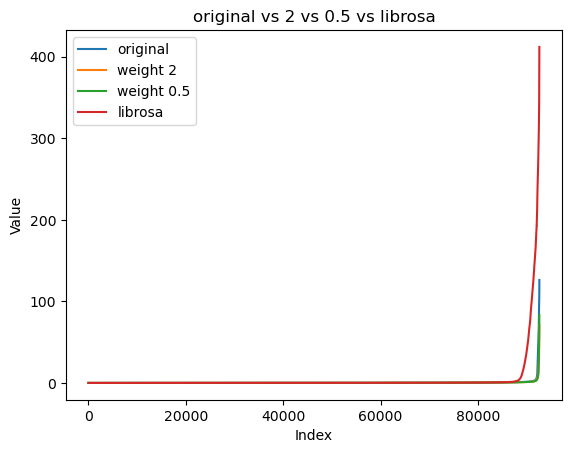

In [25]:
datas = [[item['deviation'] for item in segments_global_sorted_deviation],
        [item['deviation'] for item in segments_global_sorted_deviation_2],
        [item['deviation'] for item in segments_global_sorted_deviation_5],
        [item['deviation'] for item in segments_global_sorted_deviation_librosa]]

labels = ["original", "weight 2", "weight 0.5", "librosa"]

plot_multiple_arrays(datas, labels, "original vs 2 vs 0.5 vs librosa")


In [ ]:
Max, median and the mean of deviations of the 210 pairs for the 4 cost matrices.

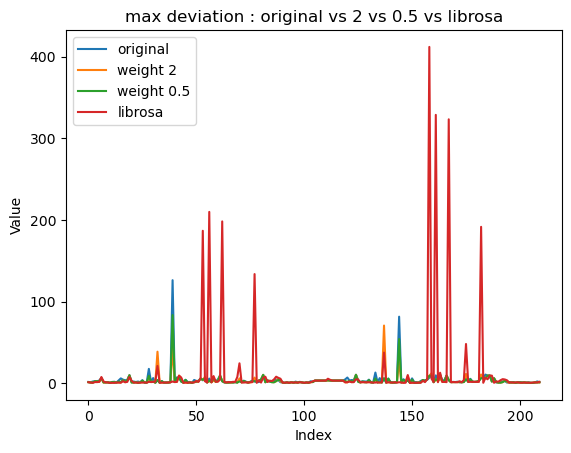

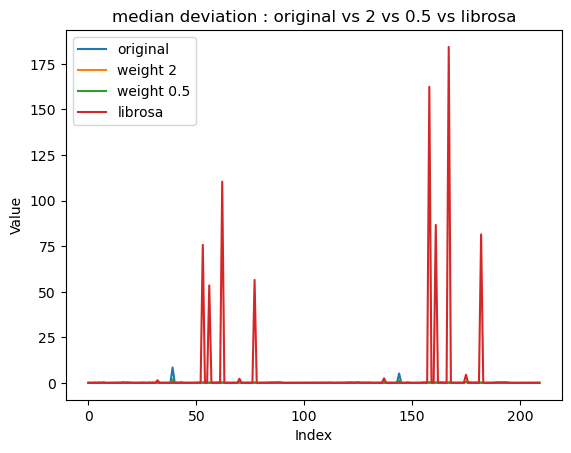

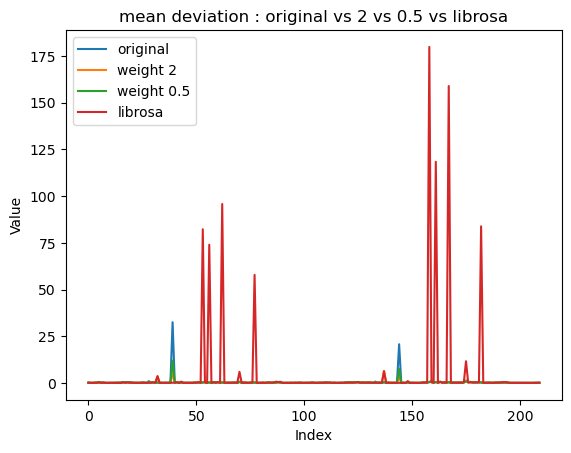

In [33]:

max_dev_arr = numpy.zeros(len(deviation_arr) * 2)
max_dev_arr_2 = numpy.zeros(len(deviation_arr) * 2)
max_dev_arr_5 = numpy.zeros(len(deviation_arr) * 2)
max_dev_arr_librosa = numpy.zeros(len(deviation_arr) * 2)

median_dev_arr = numpy.zeros(len(deviation_arr) * 2)
median_dev_arr_2 = numpy.zeros(len(deviation_arr) * 2)
median_dev_arr_5 = numpy.zeros(len(deviation_arr) * 2)
median_dev_arr_librosa = numpy.zeros(len(deviation_arr) * 2)

mean_dev_arr = numpy.zeros(len(deviation_arr) * 2)
mean_dev_arr_2 = numpy.zeros(len(deviation_arr) * 2)
mean_dev_arr_5 = numpy.zeros(len(deviation_arr) * 2)
mean_dev_arr_librosa = numpy.zeros(len(deviation_arr) * 2)

for i in range(len(deviation_arr)):

    max_dev_arr[i] = numpy.max(deviation_arr[i])
    max_dev_arr[i + len(deviation_arr)] = numpy.max(deviation_swap_arr[i])

    max_dev_arr_2[i] = numpy.max(deviation_arr_2[i])
    max_dev_arr_2[i + len(deviation_arr)] = numpy.max(deviation_swap_arr_2[i])

    max_dev_arr_5[i] = numpy.max(deviation_arr_5[i])
    max_dev_arr_5[i + len(deviation_arr)] = numpy.max(deviation_swap_arr_5[i])

    max_dev_arr_librosa[i] = numpy.max(deviation_arr_librosa[i])
    max_dev_arr_librosa[i + len(deviation_arr)] = numpy.max(deviation_swap_arr_librosa[i])

    median_dev_arr[i] = numpy.median(deviation_arr[i])
    median_dev_arr[i + len(deviation_arr)] = numpy.median(deviation_swap_arr[i])

    median_dev_arr_2[i] = numpy.median(deviation_arr_2[i])
    median_dev_arr_2[i + len(deviation_arr)] = numpy.median(deviation_swap_arr_2[i])

    median_dev_arr_5[i] = numpy.median(deviation_arr_5[i])
    median_dev_arr_5[i + len(deviation_arr)] = numpy.median(deviation_swap_arr_5[i])

    median_dev_arr_librosa[i] = numpy.median(deviation_arr_librosa[i])
    median_dev_arr_librosa[i + len(deviation_arr)] = numpy.median(deviation_swap_arr_librosa[i])

    mean_dev_arr[i] = numpy.mean(deviation_arr[i])
    mean_dev_arr[i + len(deviation_arr)] = numpy.mean(deviation_swap_arr[i])

    mean_dev_arr_2[i] = numpy.mean(deviation_arr_2[i])
    mean_dev_arr_2[i + len(deviation_arr)] = numpy.mean(deviation_swap_arr_2[i])

    mean_dev_arr_5[i] = numpy.mean(deviation_arr_5[i])
    mean_dev_arr_5[i + len(deviation_arr)] = numpy.mean(deviation_swap_arr_5[i])

    mean_dev_arr_librosa[i] = numpy.mean(deviation_arr_librosa[i])
    mean_dev_arr_librosa[i + len(deviation_arr)] = numpy.mean(deviation_swap_arr_librosa[i])

datas = [max_dev_arr, max_dev_arr_2, max_dev_arr_5, max_dev_arr_librosa]
labels = ["original", "weight 2", "weight 0.5", "librosa"]

plot_multiple_arrays(datas, labels, "max deviation : original vs 2 vs 0.5 vs librosa")

datas = [median_dev_arr, median_dev_arr_2, median_dev_arr_5, median_dev_arr_librosa]
labels = ["original", "weight 2", "weight 0.5", "librosa"]

plot_multiple_arrays(datas, labels, "median deviation : original vs 2 vs 0.5 vs librosa")

datas = [mean_dev_arr, mean_dev_arr_2, mean_dev_arr_5, mean_dev_arr_librosa]
labels = ["original", "weight 2", "weight 0.5", "librosa"]

plot_multiple_arrays(datas, labels, "mean deviation : original vs 2 vs 0.5 vs librosa")


Max, median and the mean of energy of deviations of the 210 pairs for the 4 cost matrices.
It can be seen that the energy does not correlate well with the deviation.
That is - pairs with high deviation do not show high energy.
That is because of the normalization as explained before.
While this can be said to be as expected, in our case of continuous speech
a pair having a mean deviation of 20 secs in one cost matrix should surely have higher normalized energy
than in another cost matrix that has a 2 sec mean deviation.

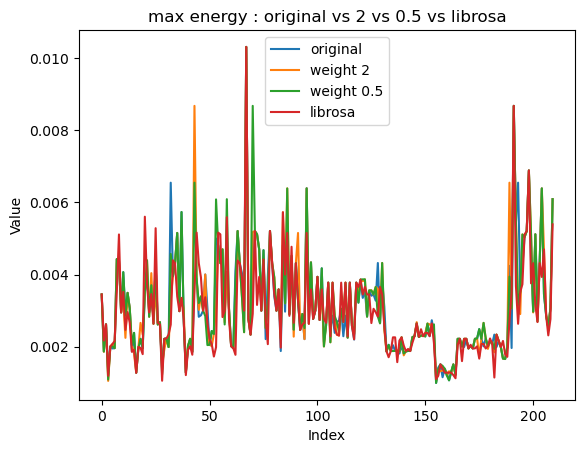

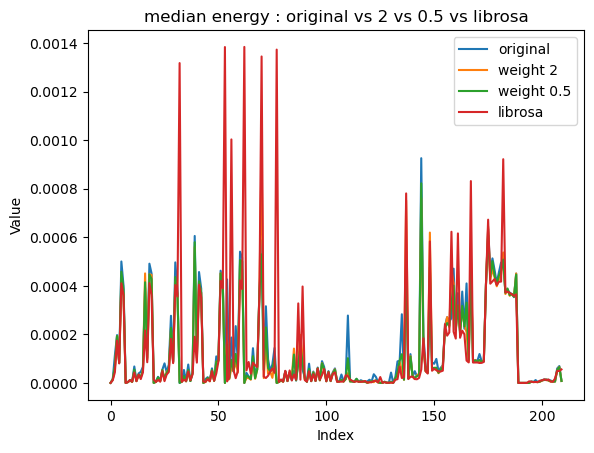

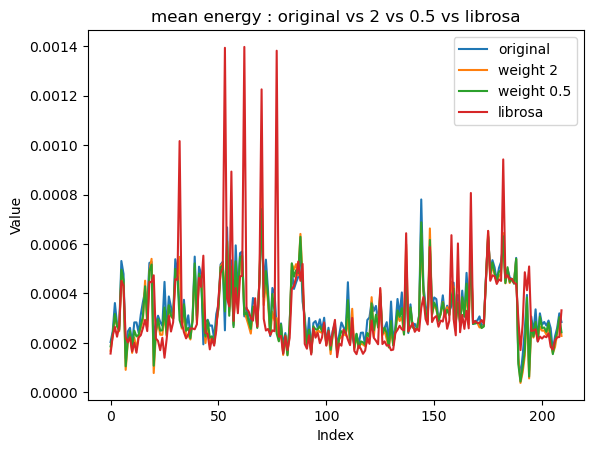

In [32]:

max_energy_arr = numpy.zeros(len(energy_arr) * 2)
max_energy_arr_2 = numpy.zeros(len(energy_arr) * 2)
max_energy_arr_5 = numpy.zeros(len(energy_arr) * 2)
max_energy_arr_librosa = numpy.zeros(len(energy_arr) * 2)

median_energy_arr = numpy.zeros(len(energy_arr) * 2)
median_energy_arr_2 = numpy.zeros(len(energy_arr) * 2)
median_energy_arr_5 = numpy.zeros(len(energy_arr) * 2)
median_energy_arr_librosa = numpy.zeros(len(energy_arr) * 2)

mean_energy_arr = numpy.zeros(len(energy_arr) * 2)
mean_energy_arr_2 = numpy.zeros(len(energy_arr) * 2)
mean_energy_arr_5 = numpy.zeros(len(energy_arr) * 2)
mean_energy_arr_librosa = numpy.zeros(len(energy_arr) * 2)

for i in range(len(energy_arr)):

    max_energy_arr[i] = numpy.max(energy_arr[i])
    max_energy_arr[i + len(energy_arr)] = numpy.max(energy_swap_arr[i])

    max_energy_arr_2[i] = numpy.max(energy_arr_2[i])
    max_energy_arr_2[i + len(energy_arr)] = numpy.max(energy_swap_arr_2[i])

    max_energy_arr_5[i] = numpy.max(energy_arr_5[i])
    max_energy_arr_5[i + len(energy_arr)] = numpy.max(energy_swap_arr_5[i])

    max_energy_arr_librosa[i] = numpy.max(energy_arr_librosa[i])
    max_energy_arr_librosa[i + len(energy_arr)] = numpy.max(energy_swap_arr_librosa[i])

    median_energy_arr[i] = numpy.median(energy_arr[i])
    median_energy_arr[i + len(energy_arr)] = numpy.median(energy_swap_arr[i])

    median_energy_arr_2[i] = numpy.median(energy_arr_2[i])
    median_energy_arr_2[i + len(energy_arr)] = numpy.median(energy_swap_arr_2[i])

    median_energy_arr_5[i] = numpy.median(energy_arr_5[i])
    median_energy_arr_5[i + len(energy_arr)] = numpy.median(energy_swap_arr_5[i])

    median_energy_arr_librosa[i] = numpy.median(energy_arr_librosa[i])
    median_energy_arr_librosa[i + len(energy_arr)] = numpy.median(energy_swap_arr_librosa[i])

    mean_energy_arr[i] = numpy.mean(energy_arr[i])
    mean_energy_arr[i + len(energy_arr)] = numpy.mean(energy_swap_arr[i])

    mean_energy_arr_2[i] = numpy.mean(energy_arr_2[i])
    mean_energy_arr_2[i + len(energy_arr)] = numpy.mean(energy_swap_arr_2[i])

    mean_energy_arr_5[i] = numpy.mean(energy_arr_5[i])
    mean_energy_arr_5[i + len(energy_arr)] = numpy.mean(energy_swap_arr_5[i])

    mean_energy_arr_librosa[i] = numpy.mean(energy_arr_librosa[i])
    mean_energy_arr_librosa[i + len(energy_arr)] = numpy.mean(energy_swap_arr_librosa[i])

datas = [max_energy_arr, max_energy_arr_2, max_energy_arr_5, max_energy_arr_librosa]
labels = ["original", "weight 2", "weight 0.5", "librosa"]

plot_multiple_arrays(datas, labels, "max energy : original vs 2 vs 0.5 vs librosa")

datas = [median_energy_arr, median_energy_arr_2, median_energy_arr_5, median_energy_arr_librosa]
labels = ["original", "weight 2", "weight 0.5", "librosa"]

plot_multiple_arrays(datas, labels, "median energy : original vs 2 vs 0.5 vs librosa")

datas = [mean_energy_arr, mean_energy_arr_2, mean_energy_arr_5, mean_energy_arr_librosa]
labels = ["original", "weight 2", "weight 0.5", "librosa"]

plot_multiple_arrays(datas, labels, "mean energy : original vs 2 vs 0.5 vs librosa")


But if we remove the normalisation, the pairs with higher deviations show higher energies.

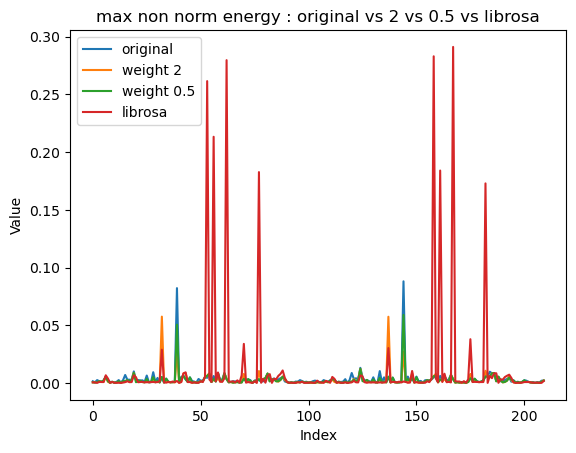

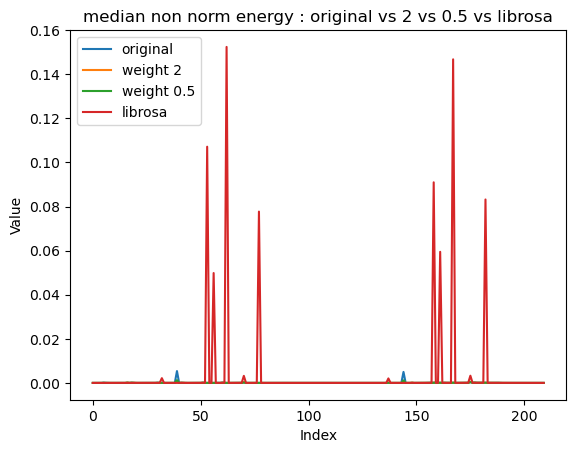

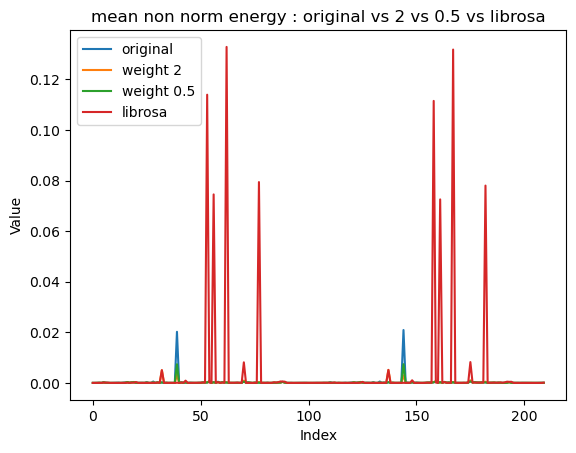

In [31]:

max_non_norm_energy_arr = numpy.zeros(len(non_norm_energy_arr) * 2)
max_non_norm_energy_arr_2 = numpy.zeros(len(non_norm_energy_arr) * 2)
max_non_norm_energy_arr_5 = numpy.zeros(len(non_norm_energy_arr) * 2)
max_non_norm_energy_arr_librosa = numpy.zeros(len(non_norm_energy_arr) * 2)

median_non_norm_energy_arr = numpy.zeros(len(non_norm_energy_arr) * 2)
median_non_norm_energy_arr_2 = numpy.zeros(len(non_norm_energy_arr) * 2)
median_non_norm_energy_arr_5 = numpy.zeros(len(non_norm_energy_arr) * 2)
median_non_norm_energy_arr_librosa = numpy.zeros(len(non_norm_energy_arr) * 2)

mean_non_norm_energy_arr = numpy.zeros(len(non_norm_energy_arr) * 2)
mean_non_norm_energy_arr_2 = numpy.zeros(len(non_norm_energy_arr) * 2)
mean_non_norm_energy_arr_5 = numpy.zeros(len(non_norm_energy_arr) * 2)
mean_non_norm_energy_arr_librosa = numpy.zeros(len(non_norm_energy_arr) * 2)

for i in range(len(non_norm_energy_arr)):

    max_non_norm_energy_arr[i] = numpy.max(non_norm_energy_arr[i])
    max_non_norm_energy_arr[i + len(non_norm_energy_arr)] = numpy.max(non_norm_energy_swap_arr[i])

    max_non_norm_energy_arr_2[i] = numpy.max(non_norm_energy_arr_2[i])
    max_non_norm_energy_arr_2[i + len(non_norm_energy_arr)] = numpy.max(non_norm_energy_swap_arr_2[i])

    max_non_norm_energy_arr_5[i] = numpy.max(non_norm_energy_arr_5[i])
    max_non_norm_energy_arr_5[i + len(non_norm_energy_arr)] = numpy.max(non_norm_energy_swap_arr_5[i])

    max_non_norm_energy_arr_librosa[i] = numpy.max(non_norm_energy_arr_librosa[i])
    max_non_norm_energy_arr_librosa[i + len(non_norm_energy_arr)] = numpy.max(non_norm_energy_swap_arr_librosa[i])

    median_non_norm_energy_arr[i] = numpy.median(non_norm_energy_arr[i])
    median_non_norm_energy_arr[i + len(non_norm_energy_arr)] = numpy.median(non_norm_energy_swap_arr[i])

    median_non_norm_energy_arr_2[i] = numpy.median(non_norm_energy_arr_2[i])
    median_non_norm_energy_arr_2[i + len(non_norm_energy_arr)] = numpy.median(non_norm_energy_swap_arr_2[i])

    median_non_norm_energy_arr_5[i] = numpy.median(non_norm_energy_arr_5[i])
    median_non_norm_energy_arr_5[i + len(non_norm_energy_arr)] = numpy.median(non_norm_energy_swap_arr_5[i])

    median_non_norm_energy_arr_librosa[i] = numpy.median(non_norm_energy_arr_librosa[i])
    median_non_norm_energy_arr_librosa[i + len(non_norm_energy_arr)] = numpy.median(non_norm_energy_swap_arr_librosa[i])

    mean_non_norm_energy_arr[i] = numpy.mean(non_norm_energy_arr[i])
    mean_non_norm_energy_arr[i + len(non_norm_energy_arr)] = numpy.mean(non_norm_energy_swap_arr[i])

    mean_non_norm_energy_arr_2[i] = numpy.mean(non_norm_energy_arr_2[i])
    mean_non_norm_energy_arr_2[i + len(non_norm_energy_arr)] = numpy.mean(non_norm_energy_swap_arr_2[i])

    mean_non_norm_energy_arr_5[i] = numpy.mean(non_norm_energy_arr_5[i])
    mean_non_norm_energy_arr_5[i + len(non_norm_energy_arr)] = numpy.mean(non_norm_energy_swap_arr_5[i])

    mean_non_norm_energy_arr_librosa[i] = numpy.mean(non_norm_energy_arr_librosa[i])
    mean_non_norm_energy_arr_librosa[i + len(non_norm_energy_arr)] = numpy.mean(non_norm_energy_swap_arr_librosa[i])

datas = [max_non_norm_energy_arr, max_non_norm_energy_arr_2, max_non_norm_energy_arr_5, max_non_norm_energy_arr_librosa]
labels = ["original", "weight 2", "weight 0.5", "librosa"]

plot_multiple_arrays(datas, labels, "max non norm energy : original vs 2 vs 0.5 vs librosa")

datas = [median_non_norm_energy_arr, median_non_norm_energy_arr_2, median_non_norm_energy_arr_5, median_non_norm_energy_arr_librosa]
labels = ["original", "weight 2", "weight 0.5", "librosa"]

plot_multiple_arrays(datas, labels, "median non norm energy : original vs 2 vs 0.5 vs librosa")

datas = [mean_non_norm_energy_arr, mean_non_norm_energy_arr_2, mean_non_norm_energy_arr_5, mean_non_norm_energy_arr_librosa]
labels = ["original", "weight 2", "weight 0.5", "librosa"]

plot_multiple_arrays(datas, labels, "mean non norm energy : original vs 2 vs 0.5 vs librosa")


The mean of means, medians and maxes for the deviation across the 4 cost matrices.
12 values.


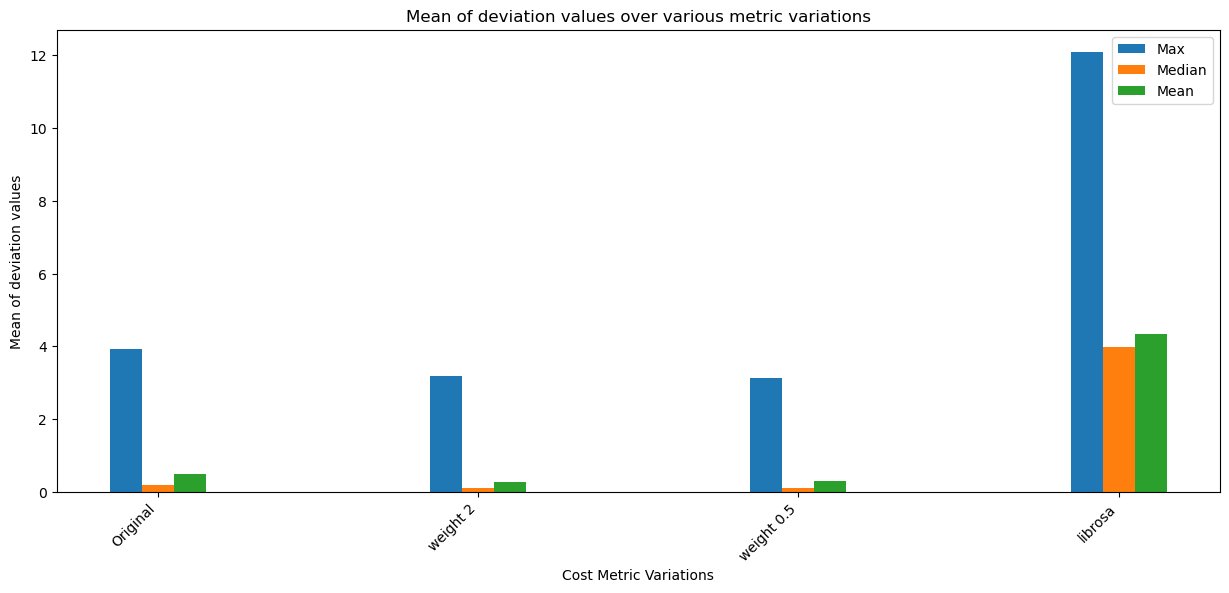

In [28]:

max_array = [numpy.mean(max_dev_arr), numpy.mean(max_dev_arr_2), 
            numpy.mean(max_dev_arr_5), numpy.mean(max_dev_arr_librosa)]
median_array = [numpy.mean(median_dev_arr), numpy.mean(median_dev_arr_2), 
            numpy.mean(median_dev_arr_5), numpy.mean(median_dev_arr_librosa)]
mean_array = [numpy.mean(mean_dev_arr), numpy.mean(mean_dev_arr_2), 
        numpy.mean(mean_dev_arr_5), numpy.mean(mean_dev_arr_librosa)]

dev_bar_arr = [max_array, median_array, mean_array]
label_arr = ["Max", "Median", "Mean"]
bar_label_arr = ["Original", "weight 2", "weight 0.5", "librosa"]
x_label = "Cost Metric Variations"
y_label = "Mean of deviation values"
title = "Mean of deviation values over various metric variations"

plot_multiple_sets_of_bars(dev_bar_arr, label_arr, bar_label_arr, x_label, y_label, title)


Observation : weight 0.5 is slightly better than weight 2.0 since it has a lower mean of maxes.

In [29]:
label_arr = ["Max", "Median", "Mean"]
for i in range(len(label_arr)):
    print("deviation : ", label_arr[i])
    print(numpy.round(dev_bar_arr[i], 3))


deviation :  Max
[ 3.938  3.19   3.135 12.095]
deviation :  Median
[0.177 0.111 0.119 3.997]
deviation :  Mean
[0.485 0.283 0.29  4.352]


The energy plots show that librosa is same or better than the aeneas variotions.
This is because of the normalization.

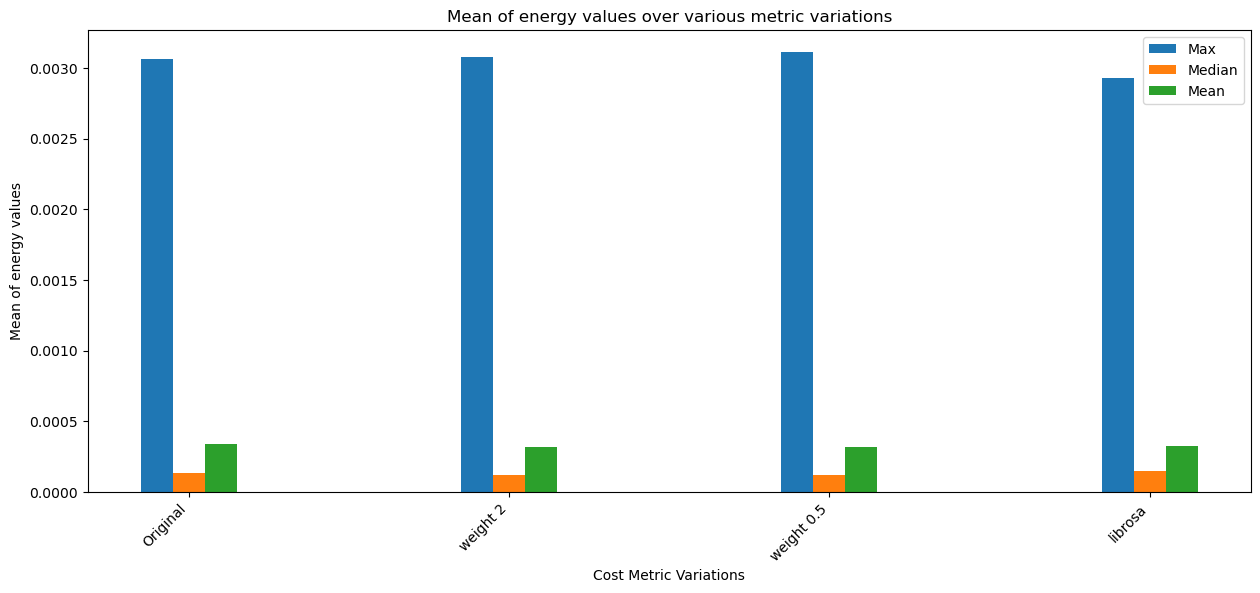

In [34]:
max_energy_array = [numpy.mean(max_energy_arr), numpy.mean(max_energy_arr_2), 
            numpy.mean(max_energy_arr_5), numpy.mean(max_energy_arr_librosa)]
median_energy_array = [numpy.mean(median_energy_arr), numpy.mean(median_energy_arr_2), 
            numpy.mean(median_energy_arr_5), numpy.mean(median_energy_arr_librosa)]
mean_energy_array = [numpy.mean(mean_energy_arr), numpy.mean(mean_energy_arr_2), 
        numpy.mean(mean_energy_arr_5), numpy.mean(mean_energy_arr_librosa)]

energy_bar_arr = [max_energy_array, median_energy_array, mean_energy_array]
label_arr = ["Max", "Median", "Mean"]
bar_label_arr = ["Original", "weight 2", "weight 0.5", "librosa"]
x_label = "Cost Metric Variations"
y_label = "Mean of energy values"
title = "Mean of energy values over various metric variations"

plot_multiple_sets_of_bars(energy_bar_arr, label_arr, bar_label_arr, x_label, y_label, title)


Without normalization the difference between librosa and aeneas can be seen.
And again weight 0.5 is slightly better than weight 2.0.

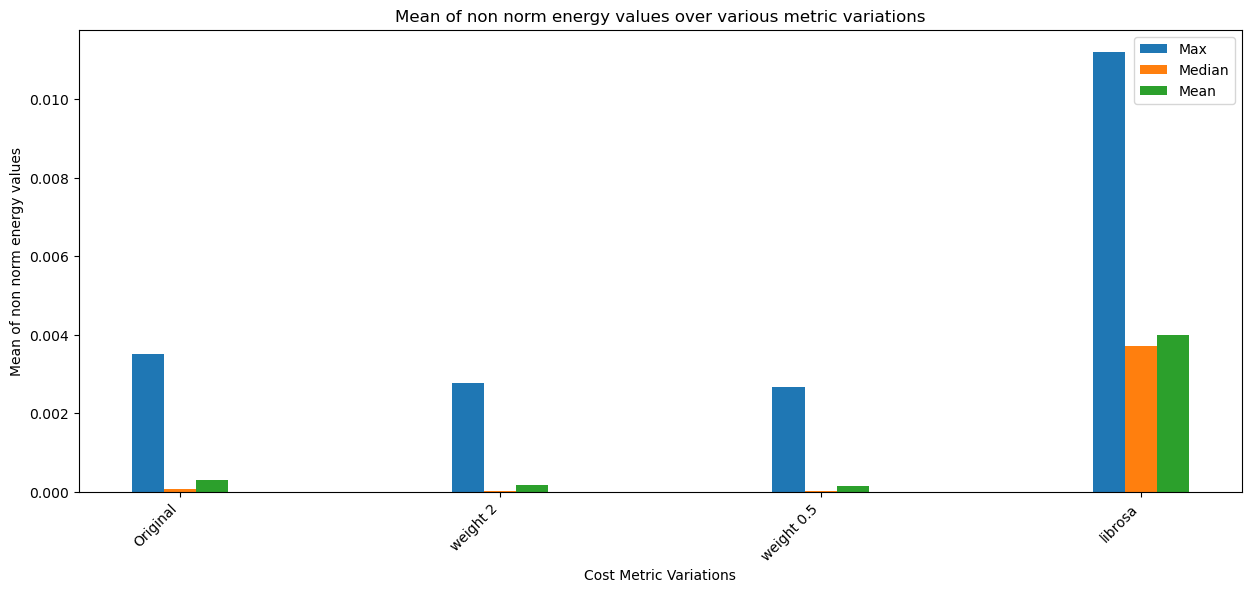

In [35]:
max_non_norm_energy_array = [numpy.mean(max_non_norm_energy_arr), numpy.mean(max_non_norm_energy_arr_2), 
            numpy.mean(max_non_norm_energy_arr_5), numpy.mean(max_non_norm_energy_arr_librosa)]
median_non_norm_energy_array = [numpy.mean(median_non_norm_energy_arr), numpy.mean(median_non_norm_energy_arr_2), 
            numpy.mean(median_non_norm_energy_arr_5), numpy.mean(median_non_norm_energy_arr_librosa)]
mean_non_norm_energy_array = [numpy.mean(mean_non_norm_energy_arr), numpy.mean(mean_non_norm_energy_arr_2), 
        numpy.mean(mean_non_norm_energy_arr_5), numpy.mean(mean_non_norm_energy_arr_librosa)]

non_norm_energy_bar_arr = [max_non_norm_energy_array, median_non_norm_energy_array, mean_non_norm_energy_array]
label_arr = ["Max", "Median", "Mean"]
bar_label_arr = ["Original", "weight 2", "weight 0.5", "librosa"]
x_label = "Cost Metric Variations"
y_label = "Mean of non norm energy values"
title = "Mean of non norm energy values over various metric variations"

plot_multiple_sets_of_bars(non_norm_energy_bar_arr, label_arr, bar_label_arr, x_label, y_label, title)


In [94]:
label_arr = ["Max", "Median", "Mean"]
for i in range(len(label_arr)):
    print("deviation : ", label_arr[i])
    print(numpy.round(dev_bar_arr[i], 3))

    print("energy : ", label_arr[i])
    print(numpy.round(energy_bar_arr[i], 5))   

    print("non norm energy : ", label_arr[i])
    print(numpy.round(non_norm_energy_bar_arr[i], 6))

deviation :  Max
[ 3.938  3.19   3.135 12.095]
energy :  Max
[0.00306 0.00308 0.00311 0.00293]
non norm energy :  Max
[0.003506 0.002774 0.002677 0.011202]
deviation :  Median
[0.177 0.111 0.119 3.997]
energy :  Median
[0.00013 0.00012 0.00012 0.00015]
non norm energy :  Median
[6.900e-05 2.400e-05 2.900e-05 3.716e-03]
deviation :  Mean
[0.485 0.283 0.29  4.352]
energy :  Mean
[0.00034 0.00031 0.00032 0.00033]
non norm energy :  Mean
[0.000316 0.000168 0.000161 0.003983]


In [96]:
label_arr = ["Max", "Median", "Mean"]
for i in range(len(label_arr)):
    print("deviation : ", label_arr[i])
    print(numpy.round(dev_bar_arr[i], 3))

    print("energy : ", label_arr[i])
    print(numpy.round(non_norm_energy_bar_arr[i], 6))

deviation :  Max
[ 3.938  3.19   3.135 12.095]
energy :  Max
[0.003506 0.002774 0.002677 0.011202]
deviation :  Median
[0.177 0.111 0.119 3.997]
energy :  Median
[6.900e-05 2.400e-05 2.900e-05 3.716e-03]
deviation :  Mean
[0.485 0.283 0.29  4.352]
energy :  Mean
[0.000316 0.000168 0.000161 0.003983]


Get the 92610 endtime deviation elements in buckets.
The number of buckets before and after the endtime deviation median can be altered.
Similarly the number of buckets can be altered for the energy.
Each endtime deviation bucket will have the deviations bucketised with respect to energy.

That is end_bkt_arr with num_bkts_bef_median=3 before and num_bkts_after_median=4 an array of length 7 (7 buckets).
Each bucket will hold the segments that fall in the bucket and also bucketise the segments
in num_energy_levels_bef_median+num_energy_levels_after_median number of buckets.


In [55]:
num_bkts_bef_median = 3
num_bkts_after_median = 4
num_energy_levels_bef_median = 2
num_energy_levels_after_median = 2

mid_idx = int(len(segments_global_sorted_deviation)/2)
deviation_median = segments_global_sorted_deviation[mid_idx]["deviation"]
energy_median = segments_global_sorted_energy[mid_idx]["energy"]

deviation_max = segments_global_sorted_deviation[-1]["deviation"]
energy_max = segments_global_sorted_energy[-1]["energy"]

deviation_bkt_arr = get_deviation_bkts_with_energy_levels(segments_global_sorted_deviation,
                                    deviation_median, deviation_max,
                                    energy_median, energy_max,
                                    num_bkts_bef_median, num_bkts_after_median, 
                                    num_energy_levels_bef_median, num_energy_levels_after_median)

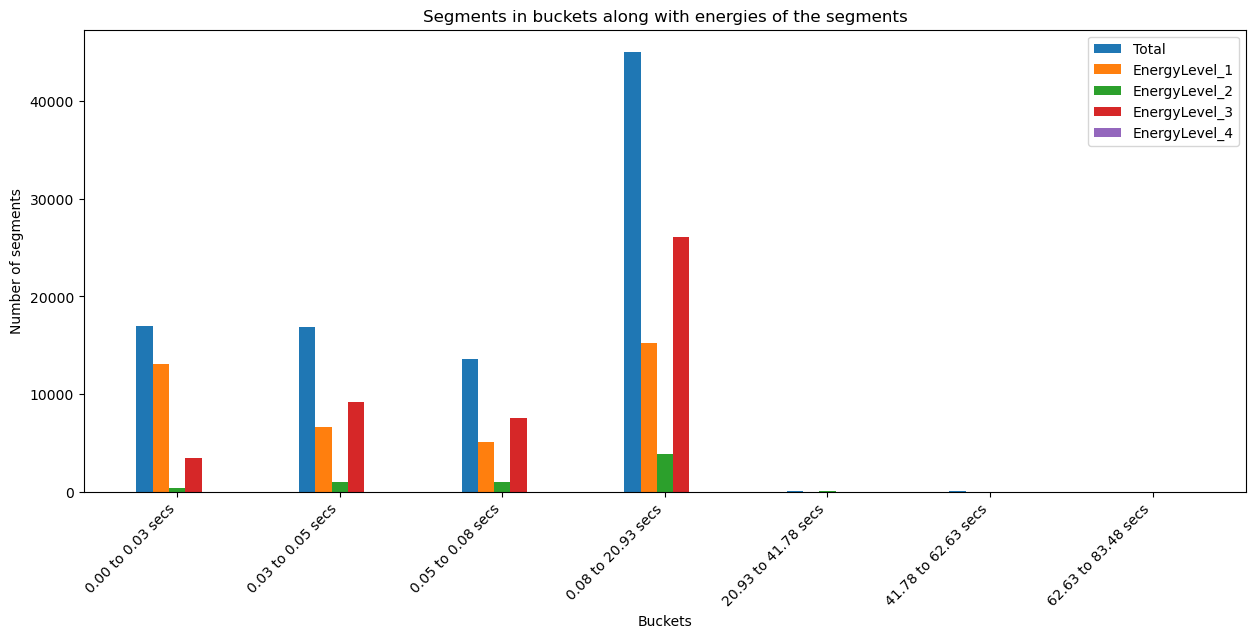

In [21]:
plot_buckets_energy(deviation_bkt_arr)

In the above plot, the number of segments in the higher buckets were too 
low to be captured well.
So zooming on that part by slicing out the higher deviation elements alone for analysis.

In [22]:
num_bkts_bef_median = 3
num_bkts_after_median = 4
num_energy_levels_bef_median = 2
num_energy_levels_after_median = 2

analyse_deviation_min = 0.09 #start from 10 secs
analyse_deviation_median = 20

analyse_part_deviation_array = []

for i in range(0, len(segments_global_sorted_deviation)):
    if (analyse_deviation_min > segments_global_sorted_deviation[i]["deviation"]):
        continue
    analyse_part_deviation_array.append(segments_global_sorted_deviation[i])

analyse_part_deviation_bkt_arr = get_deviation_bkts_with_energy_levels(analyse_part_deviation_array,
                                    analyse_deviation_median, deviation_max,
                                    energy_median, energy_max,
                                    num_bkts_bef_median, num_bkts_after_median, 
                                    num_energy_levels_bef_median, num_energy_levels_after_median)
                                    

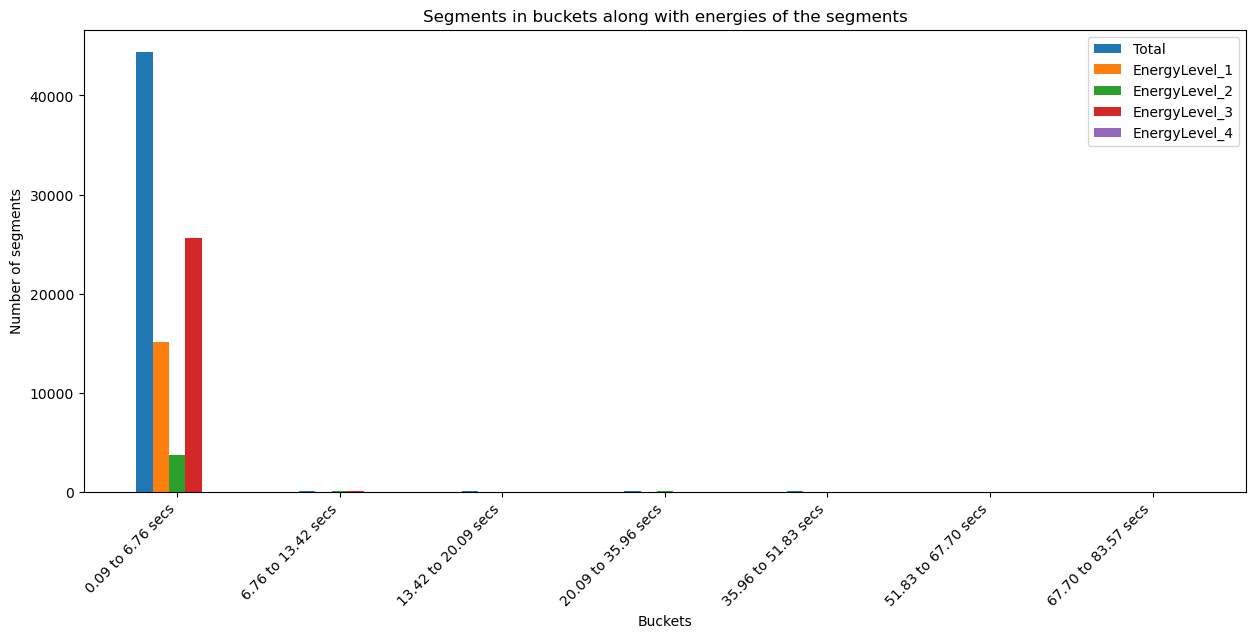

In [23]:
plot_buckets_energy(analyse_part_deviation_bkt_arr)

For doing error analysis with the segments as the cause of the error :

Consolidate all the 15*14 values for each segment. Plot the 441 endtime deviation values, 
along with the corresponding energy.

The plot will give an idea as to which part of the 441 segments are performing badly
across the 210 pairs.


In [77]:
def calc_consildated(deviation_arr, energy_arr, deviation_swap_arr, energy_swap_arr):
    
    deviation_consolidated = numpy.zeros(len(deviation_arr[0]))
    energy_consolidated = numpy.zeros(len(deviation_arr[0]))
    
    for i in range(0, len(deviation_arr)):
        for j in range(0, len(deviation_arr[i])):
            deviation_consolidated[j] += deviation_arr[i][j]
            energy_consolidated[j] += energy_arr[i][j]
    
            deviation_consolidated[j] += deviation_swap_arr[i][j]
            energy_consolidated[j] += energy_swap_arr[i][j]    
    
    deviation_consolidated = deviation_consolidated / (len(deviation_arr) * 2)
    energy_consolidated = energy_consolidated / (len(deviation_arr) * 2)

    return deviation_consolidated, energy_consolidated

In [76]:

def plot_deviation_consolidated(deviation_consolidated, energy_consolidated, title):

    num_indices = len(deviation_consolidated)
    
    data_a = deviation_consolidated
    data_b = energy_consolidated * 300 #multiplying to make it visible
    
    # Create the plot
    plt.plot(data_a, label="End time deviation")
    plt.plot(data_b, label="Energy of deviation")
    
    # Set axis labels
    plt.xlabel("Segment Index")
    plt.ylabel("Deviation in secs")
    
    # Add a title (optional)
    plt.title(title)
    
    # Add legend
    plt.legend()
    
    # Display the plot
    plt.show()


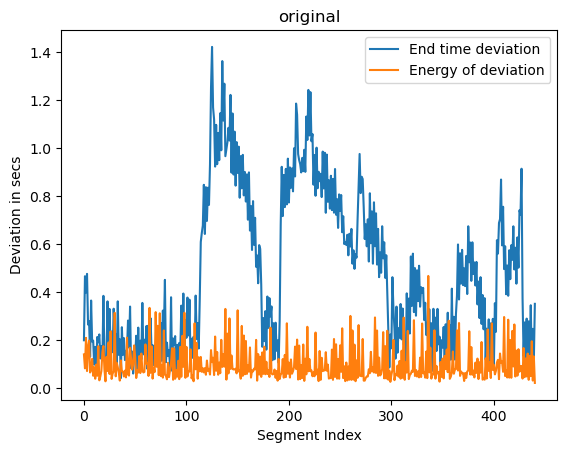

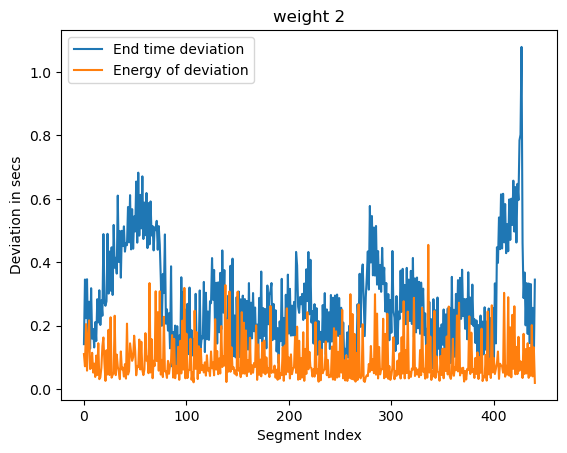

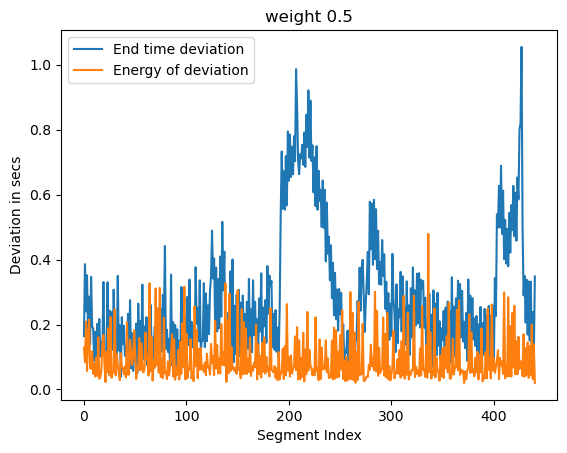

In [78]:
a, b = calc_consildated(deviation_arr, energy_arr, deviation_swap_arr, energy_swap_arr)
plot_deviation_consolidated(a, b, "original")

a, b = calc_consildated(deviation_arr_2, energy_arr_2, deviation_swap_arr_2, energy_swap_arr_2)
plot_deviation_consolidated(a, b, "weight 2")

a, b = calc_consildated(deviation_arr_5, energy_arr_5, deviation_swap_arr_5, energy_swap_arr_5)
plot_deviation_consolidated(a, b, "weight 0.5")

In [26]:
def get_deviation_buckets(deviation_arr, deviation_median, deviation_max, num_buckets_bef_median, num_buckets_after_median):
    num_buckets = num_buckets_bef_median + num_buckets_after_median
    bkt_arr = numpy.zeros(num_buckets)
    for i in range(0, len(deviation_arr)):
        found = 0
        bkt_deviation_start = 0
        for j in range(0, num_buckets):
            if (j < num_buckets_bef_median):
                bkt_deviation_end = bkt_deviation_start + deviation_median/num_bkts_bef_median
            else:
                bkt_deviation_end = bkt_deviation_start + (deviation_max - deviation_median)/num_bkts_after_median

            if (bkt_deviation_start <= deviation_arr[i] <= bkt_deviation_end):
                bkt_arr[j] += 1
                found = 1
                break
            
            bkt_deviation_start = bkt_deviation_end

        assert found == 1
    return bkt_arr

In [27]:

num_buckets_bef_median = 3
num_buckets_after_median = 4
num_energy_levels_bef_median = 2
num_energy_levels_after_median = 2

num_buckets = num_buckets_bef_median + num_buckets_after_median

segments_as_query_property = numpy.zeros((len(at_arr), num_buckets))
segments_as_ref_property = numpy.zeros((len(at_arr), num_buckets))

pair_no = 0
for r_idx in range(0, len(at_arr)):
    for q_idx in range(r_idx+1, len(at_arr)):

        segment_deviation_buckets = get_deviation_buckets(deviation_arr[pair_no],
                                                        deviation_median, deviation_max,
                                                        num_buckets_bef_median,
                                                        num_buckets_after_median)
        segments_as_query_property[q_idx] += segment_deviation_buckets
        segments_as_ref_property[r_idx] += segment_deviation_buckets        
        pair_no += 1

pair_no = 0
for q_idx in range(0, len(at_arr)):
    for r_idx in range(q_idx+1, len(at_arr)):
        segment_deviation_buckets = get_deviation_buckets(deviation_swap_arr[pair_no],
                                                        deviation_median, deviation_max,
                                                        num_buckets_bef_median,
                                                        num_buckets_after_median)
        segments_as_query_property[q_idx] += segment_deviation_buckets
        segments_as_ref_property[r_idx] += segment_deviation_buckets        
        pair_no += 1


In [28]:

def plot_segments_for_each_audio(data, dataset_type, deviation_median, deviation_max, num_buckets_bef_median, num_buckets_after_median):

    num_buckets = num_buckets_bef_median + num_buckets_after_median
    num_datasets = len(data)

    labels = []
    start = 0
    for i in range(0, num_buckets):
        if (i < num_buckets_bef_median):
            end = start + deviation_median/num_bkts_bef_median
        else:
            end = start + (deviation_max - deviation_median)/num_bkts_after_median
        labels.append("%.2f to %.2f" %(start, end))
        start = end

    # Define colors for the segments
    colors = plt.cm.viridis(numpy.linspace(0, 1, num_buckets))
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot each bar with its segments
    for i in range(num_datasets):
        bottom = 0  # Starting point for stacking
        for j in range(num_buckets):
            #ax.bar(i, data[i, j], bottom=bottom, color=colors[j], edgecolor='k', label=f'Segment {j+1}' if i == 0 else "")
            ax.bar(i, data[i, j], bottom=bottom, color=colors[j], edgecolor='k', label=labels[j])
            bottom += data[i, j]
    
    # Set labels and title
    ax.set_xlabel('Dataset Index')
    ax.set_ylabel('Num of segments')
    ax.set_title('Segment deviation as property of %s audio' %(dataset_type))
    ax.set_xticks(range(num_datasets))
    ax.set_xticklabels([f'DS {i}' for i in range(num_datasets)])
    
    # Add legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), title='Segments')

    ax.set_ylim(0, 6400)  # Set the y-axis limit

    # Show the plot
    plt.show()


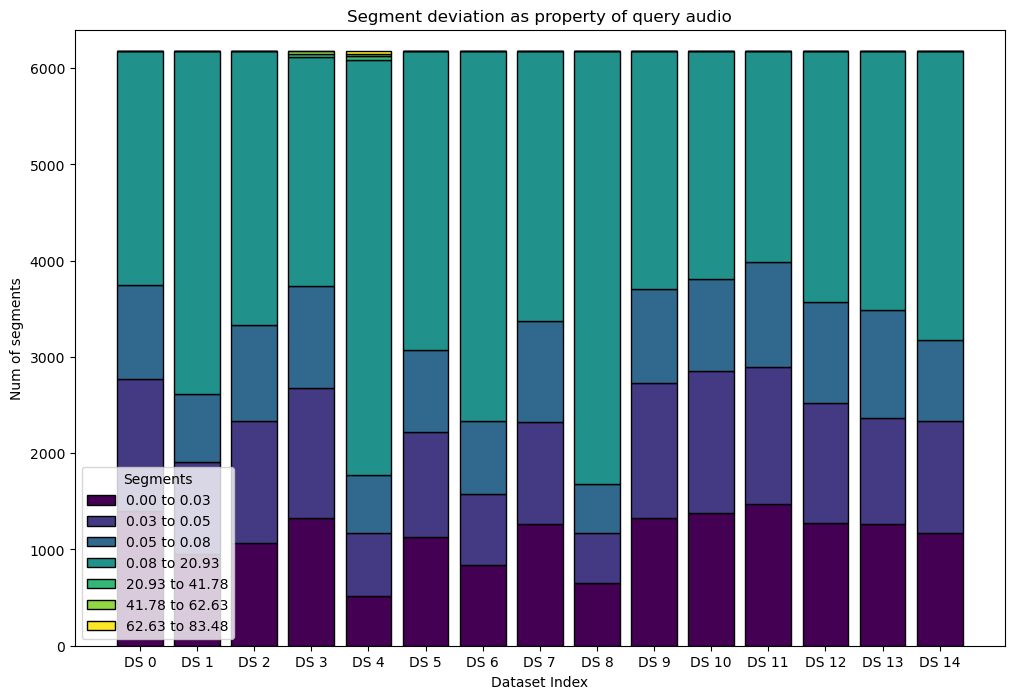

In [29]:
plot_segments_for_each_audio(segments_as_query_property, "query", deviation_median, deviation_max, num_buckets_bef_median, num_buckets_after_median)

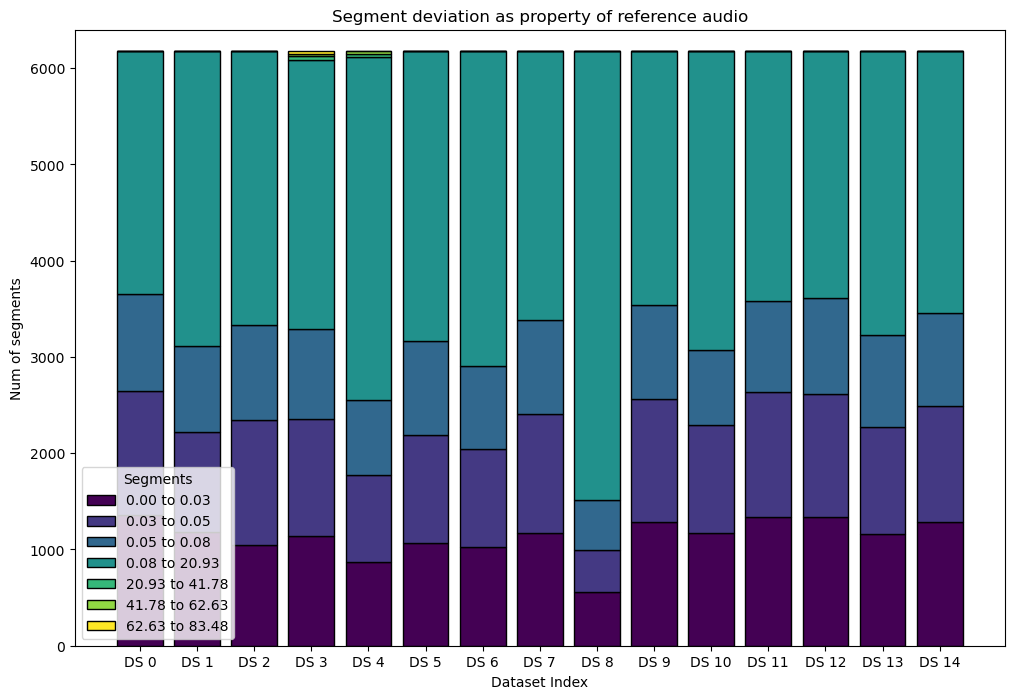

In [30]:
plot_segments_for_each_audio(segments_as_ref_property, "reference", deviation_median, deviation_max, num_buckets_bef_median, num_buckets_after_median)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_12824\1424688824.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap('tab10')  # Choose a colormap with 10 colors


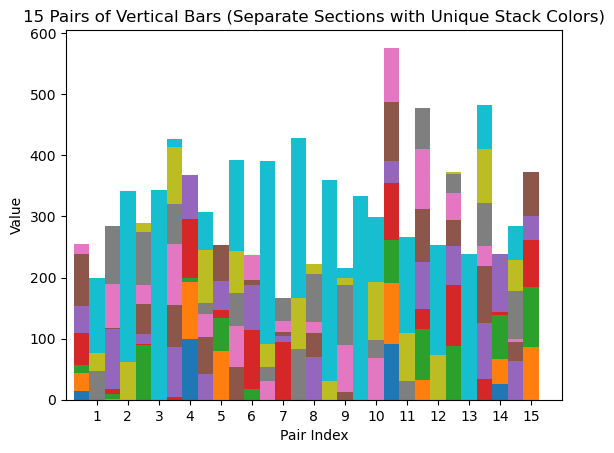

In [31]:
import matplotlib.pyplot as plt
import random

# Define number of data pairs, bar width, and segment widths
num_pairs = 15
bar_width = 0.4
segment_width_1 = bar_width / 2  # Width for first set of stacks (7)
segment_width_2 = bar_width / 2  # Width for second set of stacks (5)
total_segment_width = segment_width_1 + segment_width_2  # Combined width

# Define a color map for generating unique colors
import matplotlib.cm as cm
color_map = cm.get_cmap('tab10')  # Choose a colormap with 10 colors

# Create the plot
fig, ax = plt.subplots()

# Generate random data for each pair (7+5 elements)
data = []
for _ in range(num_pairs):
    data1 = random.sample(range(1, 101), 7)  # Generate 7 random numbers (1-100)
    data2 = random.sample(range(1, 101), 5)  # Generate 5 random numbers (1-100)
    data.append((data1, data2))

# Loop through each data pair and plot separate vertical sections with stacks
for i, (data1, data2) in enumerate(data):
    x = i * total_segment_width  # x-coordinate for the pair (considering combined width)
    bottom1 = 0  # Starting position for bottom stack (first section)
    bottom2 = 0  # Starting position for bottom stack (second section)

    # Get unique colors for EACH stack in both sections (using list comprehension)
    colors1 = [color_map(i % len(color_map.colors) + j) for j in range(len(data1))]
    colors2 = [color_map((i + len(data1)) % len(color_map.colors) + j) for j in range(len(data2))]

    # Plot stacks in the first section (7 elements)
    for j, value in enumerate(data1):
        ax.bar(x, value, segment_width_1, label=f"Pair {i+1} - Segment {j+1}", color=colors1[j], bottom=bottom1)
        bottom1 += value  # Accumulate bottom position for stacking

    # Plot stacks in the second section (5 elements)
    x += segment_width_1  # Adjust x-coordinate for the second section
    for j, value in enumerate(data2):
        ax.bar(x, value, segment_width_2, label=f"Pair {i+1} - Segment {j+8}", color=colors2[j], bottom=bottom2)
        bottom2 += value  # Accumulate bottom position for stacking

# Set labels and title
ax.set_xlabel("Pair Index")
ax.set_ylabel("Value")
ax.set_title("15 Pairs of Vertical Bars (Separate Sections with Unique Stack Colors)")

# Remove legend (as requested)
# ax.legend(loc='upper left')  # Uncomment to display legend

# Adjust x-axis limits for better spacing
plt.xlim(-total_segment_width / 2, num_pairs * total_segment_width + total_segment_width / 2)

# Fix for error (already included)
x_ticks = [i * total_segment_width + total_segment_width / 2 for i in range(num_pairs)]
plt.xticks(x_ticks, range(1, 16))

# Show the plot
plt.show()
